In [207]:
import scipy         
import datetime
from scipy.linalg import expm,det
import scipy.sparse as sparse
from quspin.operators import hamiltonian, commutator, exp_op # Hamiltonians and operators
from quspin.basis import tensor_basis, spin_basis_1d # bases
import numpy as np # general math functions
import matplotlib.pyplot as plt # plotting library
from numba import jit
from scipy.integrate import solve_ivp,odeint
from functools import reduce


In [208]:
L = 3 #system size
l=1 #spin length
M = 0.1
m_epsilon = 0
N=3
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)

In [209]:
#construct basis
basis=spin_basis_1d(L=L,S = str(l))
print(basis)

reference states: 
array index   /   Fock state   /   integer repr. 
      0.         |2 2 2>           26  
      1.         |2 2 1>           25  
      2.         |2 2 0>           24  
      3.         |2 1 2>           23  
      4.         |2 1 1>           22  
      5.         |2 1 0>           21  
      6.         |2 0 2>           20  
      7.         |2 0 1>           19  
      8.         |2 0 0>           18  
      9.         |1 2 2>           17  
     10.         |1 2 1>           16  
     11.         |1 2 0>           15  
     12.         |1 1 2>           14  
     13.         |1 1 1>           13  
     14.         |1 1 0>           12  
     15.         |1 0 2>           11  
     16.         |1 0 1>           10  
     17.         |1 0 0>            9  
     18.         |0 2 2>            8  
     19.         |0 2 1>            7  
     20.         |0 2 0>            6  
     21.         |0 1 2>            5  
     22.         |0 1 1>            4  
     23.   

In [210]:
#initialisation of the Gauss laws

liste = []
liste_m = []
gauss_law_map = []
Gauss_law = []
gauss_law_matrix = []
z_comp_minf = [[-m_epsilon,0]]
z_comp_pinf = [[m_epsilon,L-1]]

for i in range(L+1):
    liste.append([[1.,i]])
    liste_m.append([[-1.,i]])
    if i == 0:
        gauss_law_map.append([
            ["z",liste[0]],
            ["I",z_comp_minf],

        ])
    
    elif (i == L) & (i%2 == 0):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",z_comp_pinf],
        ])
    
    elif (i == L) & (i%2 == 1):
        gauss_law_map.append([
            ["z",liste_m[i-1]],
            ["I",liste[i-1]],
            ["I",z_comp_pinf],

        ])        
        
    elif i%2 == 0:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],
        ])
    elif i%2 == 1:
        gauss_law_map.append([
            ["z",liste[i]],
            ["z",liste_m[i-1]],  
            ["I",liste[i]]
        ])
    Gauss_law.append(hamiltonian(gauss_law_map[i],dynamic_list=[],basis=basis,**no_checks))
for i in range(L+1):
    gauss_law_matrix.append(Gauss_law[i].tocsc())

In [211]:
B = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        B[i][j] = (-2*l+i)**j
b = np.zeros(int(4*l)+1)
b[int(2*l)+1] = 1.
solution = scipy.linalg.solve(B,b)
y = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    y[i] = solution[i]
print(y)
print(b)

[ 0.          0.66666667  0.66666667 -0.16666667 -0.16666667  0.
  0.        ]
[0. 0. 0. 1. 0.]


In [212]:
C = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        C[i][j] = (-2*l+i+1)**j
c = np.zeros(int(4*l)+1)
c[int(2*l)] = 1.
solution = scipy.linalg.solve(C,c)
z = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    z[i] = solution[i]
print(z)
print(c)

[ 0.    1.5   0.25 -1.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [213]:
#projectors on g=1 for every site
Proj = [sparse.csr_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i] += y[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj[2*i+1] += z[j]*gauss_law_matrix[2*i+1]**j

In [214]:
A = np.zeros((int(2*l)+1,int(2*l)+1), dtype = complex)
for i in range(int(2*l)+1):
    for j in range(int(2*l)+1):
        A[i][j] = (-l+i)**j
b = np.zeros(int(2*l)+1,dtype = complex)
for i in range(int(2*l)+1):
    b[i] = (-1)**(-l+i)
solution = scipy.linalg.solve(A,b)
x = np.zeros(int(2*3/2)+1, dtype = complex)
for i in range(int(2*l)+1):
    x[i] = solution[i]
print(x)
print(x.conj())

[ 1.+0.j  0.+0.j -2.-0.j  0.+0.j]
[ 1.-0.j  0.-0.j -2.+0.j  0.-0.j]


In [215]:
D = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        D[i][j] = (-2*l+i)**j
d = np.zeros(int(4*l)+1)
d[int(2*l)] = 1.
solution = scipy.linalg.solve(D,d)
dd = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    dd[i] = solution[i]
print(dd)
print(d)

[ 1.    0.   -1.25 -0.    0.25  0.    0.  ]
[0. 0. 1. 0. 0.]


In [216]:
E = np.zeros((int(4*l)+1,int(4*l)+1))
for i in range(int(4*l)+1):
    for j in range(int(4*l)+1):
        E[i][j] = (-2*l+i+1)**j
e = np.zeros(int(4*l)+1)
e[int(2*l)-1] = 1.
solution = scipy.linalg.solve(E,e)
ee = np.zeros(int(4*3/2)+1)
for i in range(int(4*l)+1):
    ee[i] = solution[i]
print(ee)
print(e)

[ 1.         -0.83333333 -0.83333333  0.83333333 -0.16666667  0.
  0.        ]
[0. 1. 0. 0. 0.]


In [217]:
#projectors on g=0 for every site
Proj_0 = [sparse.csc_matrix((basis.Ns,basis.Ns)) for i in range(L+1)]
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i] += dd[j]*gauss_law_matrix[2*i]**j
for i in range(int(L/2)+1):
    for j in range(int(4*l)+1):
        Proj_0[2*i+1] += ee[j]*gauss_law_matrix[2*i+1]**j

In [218]:
const_term = []
linear_term = []
quadratic_term = []
cubic_term = []

const_term_conj = []
linear_term_conj = []
quadratic_term_conj = []
cubic_term_conj = []

interaction_p = []
interaction_m = []

for i in range(L-1):
    const_term.append([[x[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term.append([[x[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term.append([[x[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term.append([[(x[3])/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])

    const_term_conj.append([[x.conj()[0]/(2*np.sqrt(l*(l+1))),i]])
    linear_term_conj.append([[x.conj()[1]/(2*np.sqrt(l*(l+1))),i,i+1]])
    quadratic_term_conj.append([[x.conj()[2]/(2*np.sqrt(l*(l+1))),i,i+1,i+1]])
    cubic_term_conj.append([[x.conj()[3]/(2*np.sqrt(l*(l+1))),i,i+1,i+1,i+1]])


    interaction_p.append([
        ["+", const_term[i]],
        ["+z", linear_term[i]],
        ["+zz", quadratic_term[i]],
        ["+zzz", cubic_term[i]],


    ])

    interaction_m.append([
        ["-", const_term_conj[i]],
        ["-z", linear_term_conj[i]],
        ["-zz", quadratic_term_conj[i]],
        ["-zzz", cubic_term_conj[i]],


    ])
    
const_term.append([[(0.5*(-1)**m_epsilon)/np.sqrt(l*(l+1)),L-1]])
const_term_conj.append([[(0.5*np.conj((-1)**m_epsilon))/np.sqrt(l*(l+1)),L-1]])

interaction_p.append([
    ["+", const_term[L-1]]
])
interaction_m.append([
    ["-", const_term_conj[L-1]]
])

kin_energy = [[0.5,i,i] for i in range(L)]
mass_term = [[2*(-1)**i*M,i] for i in range(L)]

kin_mass_map = [
            ["zz", kin_energy], 
            ["z", mass_term], 
]

H_int_p = []
H_int_m = []
interaction = [sparse.csr_matrix((basis.Ns,basis.Ns),dtype = complex) for i in range(L)]
h_int = sparse.csr_matrix((basis.Ns,basis.Ns))
for i in range(L):
    H_int_p.append(hamiltonian(interaction_p[i],dynamic_list=[],basis=basis,**no_checks))
    H_int_m.append(hamiltonian(interaction_m[i],dynamic_list=[],basis=basis,**no_checks))
    interaction[i] = (Proj[i]@H_int_p[i].tocsc()@Proj[i+1]+Proj[i+1]@H_int_m[i].tocsc()@Proj[i])

H_kin_mass = hamiltonian(kin_mass_map,dynamic_list=[],basis=basis,**no_checks)
h_kin_mass = H_kin_mass.tocsc()

h_int = 0

for i in range(L):
    h_int += interaction[i]


full_ham_matrix = h_kin_mass + h_int #Spin-1 Hamiltonian without the local contstaints

for i in range(L+1):
    full_ham_matrix = (Proj[i]+Proj_0[i])@full_ham_matrix@(Proj[i]+Proj_0[i])
full_ham_matrix = 1.*full_ham_matrix

G=0
for i in range(L+1):
    G += 10*(Gauss_law[i]**2-Gauss_law[i])**2
constraint_full_matrix = G.tocsc()
constrained_full_ham_matrix= 1*(full_ham_matrix + constraint_full_matrix) #Spin-1 Hamiltonian with the local contstaints as a penalty term


In [219]:
#eigenvalues and eigenvectors of the Spin-1 Hamiltonian without the local contstaints
eigenval, eigenvec = scipy.sparse.linalg.eigsh(constrained_full_ham_matrix,k = 3,which = "SA")
print(eigenval[eigenval<=1e1])


[-0.64551385  0.42748942  0.7       ]


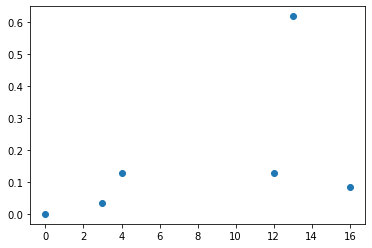

In [220]:
y = []
x = []
for i in range(basis.Ns):
    if np.abs(eigenvec[:,0][i])**2>=1e-4:
        y.append(np.abs(eigenvec[:,0][i])**2) 
        x.append(i)
plt.plot(x,y, "o")


In [221]:
def rot_sigma(k,i,j,phi,theta):
    if k>=L:
        print("Warning! Rotations apply to k<=L-1!")
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    rot_matrix = expm(-1j*theta*sigma)
    if k==0:
        tensprod = rot_matrix
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,rot_matrix)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def rot_sigma_e(i,j,phi,theta):
    sigma_e = sparse.identity(basis.Ns,dtype = complex)
    for k in range(1,int(L/2)):
        sigma_e = rot_sigma(2*k,i,j,phi,theta)@sigma_e
    return(sigma_e)

def rot_sigma_o(i,j,phi,theta):
    sigma_o = sparse.identity(basis.Ns,dtype = complex)
    for k in range(int(L/2)):
        sigma_o = rot_sigma(2*k+1,i,j,phi,theta)@sigma_o
    return(sigma_o)

def rot_sigma_r(i,j,phi,theta):
    sigma_r = sparse.identity(basis.Ns,dtype = complex)
    sigma_r = rot_sigma(0,i,j,phi,theta)@rot_sigma(L-1,i,j,phi,theta)
    return(sigma_r)


def sigma(k,i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    if k==0:
        tensprod = sigma
        for i in range(L-1):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    else:
        tensprod = sparse.identity(2*l+1)
        for i in range(1,k):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
        tensprod = scipy.sparse.kron(tensprod,sigma)
        for i in range(k+1,L):
            tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
    return tensprod


def sigma_e(i,j,phi):
    sigma_e = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_e = sparse.csc_matrix(sigma_e)
    for k in range(1,int(L/2)):
        sigma_e +=sigma(2*k,i,j,phi)
    return sigma_e

def sigma_o(i,j,phi):
    sigma_o = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_o = sparse.csc_matrix(sigma_o)
    for k in range(int(L/2)):
        sigma_o +=sigma(2*k+1,i,j,phi)
    return sigma_o

def sigma_r(i,j,phi):
    sigma_r = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    sigma_r = sparse.csc_matrix(sigma_r)
    sigma_r = sigma(0,i,j,phi)+sigma(L-1,i,j,phi)
    return sigma_r

In [222]:

def ms_hamiltonian(i,j,phi):
    sigma = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma[2*l-i][2*l-j] = 0.5*(np.cos(phi)+1j*np.sin(phi))
    sigma[2*l-j][2*l-i] = 0.5*(np.cos(phi)-1j*np.sin(phi))
    sigma = sparse.csc_matrix(sigma)
    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for k in range(L):
        if k == 0:
            tensprod = sigma
            for m in range(L-1):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        else:
            tensprod = sparse.identity(2*l+1)
            for i in range(1,k):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = scipy.sparse.kron(tensprod,sigma)
            for i in range(k+1,L):
                tensprod = scipy.sparse.kron(tensprod,sparse.identity(2*l+1))
            tensprod = tensprod.toarray()
        summe +=tensprod
    return summe@summe
                
matrix_part = ms_hamiltonian(1,2,0)
ms_ham_eigenval, ms_ham_eigenvec = scipy.linalg.eigh(matrix_part)




def ms_gate_global(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec@exponential@ms_ham_eigenvec.T.conj()

    
def ms_hamiltonian_1(i,j,phi):
    sigma_p = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_m = np.zeros((2*l+1,2*l+1),dtype = complex)
    sigma_z = np.zeros((2*l+1,2*l+1),dtype = complex)
    
    sigma_p[2*l-j][2*l-i] = 1.
    sigma_m[2*l-i][2*l-j] = 1.
    
    sigma_z[2*l-i][2*l-i] = 1.
    sigma_z[2*l-j][2*l-j] = -1.
    
    sigma_p = sparse.csc_matrix(sigma_p)
    sigma_m = sparse.csc_matrix(sigma_m)
    sigma_z = sparse.csc_matrix(sigma_z)

    sigma_big_p = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_m = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]
    sigma_big_z = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for n in range(L)]

    summe = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    
    for k in range(L):
        if k == 0:
            tensprod_p = sigma_p
            tensprod_m = sigma_m
            tensprod_z = sigma_z

            for m in range(L-1):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()
            tensprod_z = tensprod_z.toarray()
        else:
            tensprod_p = sparse.identity(2*l+1)
            tensprod_m = sparse.identity(2*l+1)
            tensprod_z = sparse.identity(2*l+1)
            
            for i in range(1,k):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = scipy.sparse.kron(tensprod_p,sigma_p)
            tensprod_m = scipy.sparse.kron(tensprod_m,sigma_m)
            tensprod_z = scipy.sparse.kron(tensprod_z,sigma_z)            
            for i in range(k+1,L):
                tensprod_p = scipy.sparse.kron(tensprod_p,sparse.identity(2*l+1))
                tensprod_m = scipy.sparse.kron(tensprod_m,sparse.identity(2*l+1))
                tensprod_z = scipy.sparse.kron(tensprod_z,sparse.identity(2*l+1))
            tensprod_p = tensprod_p.toarray()
            tensprod_m = tensprod_m.toarray()    
            tensprod_z = tensprod_z.toarray() 
            
        sigma_big_p[k] = tensprod_p
        sigma_big_m[k] = tensprod_m
        sigma_big_z[k] = tensprod_z

    for k in range(L):
        summe += 1.*sigma_big_z[k]
        for kk in range(k+1,L):
            summe += 1./np.abs(k-kk)**2*(sigma_big_p[k]@sigma_big_m[kk] + sigma_big_m[k]@sigma_big_p[kk])
    return summe
                
matrix_part_1 = ms_hamiltonian_1(1,2,0)
ms_ham_eigenval_1, ms_ham_eigenvec_1 = scipy.linalg.eigh(matrix_part_1)




def ms_gate_global_1(theta):
    exponential = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    for i in range(basis.Ns):
        exponential[i][i] = np.exp(-1j*ms_ham_eigenval_1[i]*theta)
    exponential = scipy.sparse.csc_matrix(exponential)
    return ms_ham_eigenvec_1@exponential@ms_ham_eigenvec_1.T.conj()

In [223]:
def swap(m,n):
    swap_matrix = np.zeros((basis.Ns,basis.Ns),dtype = complex)
    swap_matrix = sparse.csc_matrix(swap_matrix)
    for i in range(basis.Ns):
        state_m = basis.int_to_state(basis.Ns-i-1)[2*m+1]
        state_n = basis.int_to_state(basis.Ns-i-1)[2*n+1]
        string = list(basis.int_to_state(basis.Ns-i-1))
        string[2*m+1],string[2*n+1] = state_n,state_m
        string = "".join(string)
        string = string.replace(" ", "")
        string = string.replace("|","")
        string = string.replace(">", "")
        i_new = basis.Ns-1-basis.state_to_int(string)
        swap_matrix[i_new,i] = 1.
        
    return swap_matrix


def exp_gate(k,kk,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = np.cos(theta/2)
    Matrix[8-1,8-1] = np.cos(theta/2)
    Matrix[8-2,8-2] = 0

    Matrix[8-3,8-3] = np.cos(theta/2)
    Matrix[8-4,8-4] = np.cos(theta/2)
    Matrix[8-5,8-5] = 0

    Matrix[8-6,8-6] = -np.cos(theta/2)
    Matrix[8-7,8-7] = np.cos(theta/2)
    Matrix[8-8,8-8] = -1j

    Matrix[8-0,8-4] = -1j*np.sin(theta/2)
    Matrix[8-4,8-0] = -1j*np.sin(theta/2)

    Matrix[8-1,8-3] = -1j*np.sin(theta/2)
    Matrix[8-3,8-1] = -1j*np.sin(theta/2)


    Matrix[8-5,8-2] = -1
    Matrix[8-2,8-5] = -1

    Matrix[8-6,8-7] = np.sin(theta/2)
    Matrix[8-7,8-6] = np.sin(theta/2)
    
    if np.abs(k-kk) == 1:


        if k == 0:
            Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))

        else:
            Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
            Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))
        return Matrix_full
    
    else:
        
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))


        return swap(0,k)@swap(1,kk)@Matrix_full@swap(1,kk)@swap(0,k)


In [224]:
def exp_gate_der(k,kk,theta):
    Matrix = np.zeros((9,9),dtype = complex)
    Matrix = sparse.csc_matrix(Matrix)
    Matrix[8-0,8-0] = -np.sin(theta/2)/2
    Matrix[8-1,8-1] = -np.sin(theta/2)/2

    Matrix[8-3,8-3] = -np.sin(theta/2)/2
    Matrix[8-4,8-4] = -np.sin(theta/2)/2

    Matrix[8-6,8-6] = np.sin(theta/2)/2
    Matrix[8-7,8-7] = -np.sin(theta/2)/2

    Matrix[8-0,8-4] = -1j*np.cos(theta/2)/2
    Matrix[8-4,8-0] = -1j*np.cos(theta/2)/2

    Matrix[8-1,8-3] = -1j*np.cos(theta/2)/2
    Matrix[8-3,8-1] = -1j*np.cos(theta/2)/2



    Matrix[8-6,8-7] = np.cos(theta/2)/2
    Matrix[8-7,8-6] = np.cos(theta/2)/2
  

    if np.abs(k-kk) == 1:


        if k == 0:
            Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))

        else:
            Matrix_full = scipy.sparse.kron(sparse.identity(3**k),Matrix)
            Matrix_full = scipy.sparse.kron(Matrix_full,sparse.identity(3**((L-2)-k)))
        return Matrix_full
    else:
        Matrix_full = scipy.sparse.kron(Matrix,sparse.identity(3**(L-2)))

        return swap(0,k)@swap(1,k+2)@Matrix_full@swap(1,k+2)@swap(0,k)




In [225]:
%time exp_gate_der(0,2,np.pi/3)

CPU times: user 48.1 ms, sys: 17.4 ms, total: 65.5 ms
Wall time: 48.6 ms


/Users/pavelpopov/opt/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


<27x27 sparse matrix of type '<class 'numpy.complex128'>'
	with 36 stored elements in Compressed Sparse Column format>

In [226]:
#initial state
string = ""
for i in range(L):
    string +="1"
psi_0 = np.zeros(basis.Ns)
i_0 = basis.index(string)
psi_0[i_0] = 1.

In [227]:
def R(i,theta):
    
    if i%8 == 0:
        return(ms_gate_global(theta))
    
    if i%8 == 1:
        return(ms_gate_global_1(theta))


    if i%8 == 2:
        return(rot_sigma_o(0,1,0,theta))


    if i%8 == 3:
        return(rot_sigma_o(0,2,0,theta))

    
    if i%8 == 4:
        return(rot_sigma_o(1,2,np.pi/2,theta))

    
    if i%8 == 5:
        return(rot_sigma_r(0,1,0,theta))


    if i%8 == 6:
        return(rot_sigma_r(0,2,0,theta))

    
    if i%8 == 7:
        return(rot_sigma_r(1,2,np.pi/2,theta))

        

def S(i,theta):
    
    if i%8 == 0:
        return(-1j*matrix_part)
    
    if i%8 == 1:
        return(-1j*matrix_part_1)  
     
    if i%8 == 2:
        return(-1j*sigma_o(0,1,0))

    
    if i%8 == 3:
        return(-1j*sigma_o(0,2,0))

    
    if i%8 == 4:
        return(-1j*sigma_o(1,2,np.pi/2))

     
    if i%8 == 5:
        return(-1j*sigma_r(0,1,0))

    
    if i%8 == 6:
        return(-1j*sigma_r(0,2,0))
    

    if i%8 == 7:
        return(-1j*sigma_r(1,2,np.pi/2))

In [228]:
coeff = 8
stepp = 600
t_final = 10

In [229]:
expt_value_uu = []
expt_value_vv = []

time_domain = np.linspace(0, t_final, stepp)

Y = []

In [230]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p

In [231]:
for kkk in range(3):
    
    N=kkk+1
    start_point = np.zeros(coeff*N)

    matr = full_ham_matrix.toarray()
    B = [np.zeros((basis.Ns,basis.Ns),dtype = complex) for i in range(coeff*N)]
    psi_d = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s1 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]
    psi_d_s2 = [np.zeros(basis.Ns,dtype = complex) for i in range(coeff*N)]

    def rhs(t,theta):

        print(datetime.datetime.now())
        for k in range(coeff*N):
            B[k] = R(k,theta[k])

        psi_b = psi_0
        for k in range(coeff*N):
            psi_b = B[coeff*N-1-k]@psi_b
        for i in range(L+1):
            psi_b = (Proj[i]+Proj_0[i])@psi_b
        norm_b = np.sqrt(np.real(np.conj(psi_b)@psi_b))
        psi_b = psi_b/norm_b



        psi_conj_b = np.conj(psi_b)

        print("start",datetime.datetime.now())

        for k in range(coeff*N):
            B[k] = S(k,theta[k])@R(k,theta[k])
            psi_d[k] = psi_0
            for i in range(coeff*N):
                psi_d[k] = B[coeff*N-1-i]@psi_d[k]
            B[k] = R(k,theta[k])

        print("stop_reduce",datetime.datetime.now())

        psi_conj_d = np.conj(psi_d)


        for k in range(coeff*N):
            for i in range(L+1):
                psi_d_1[k] = (Proj[i]+Proj_0[i])@psi_d[k]  
            psi_d_s1[k] = psi_d_1[k]/norm_b
            psi_d_s2[k] = -psi_b*(psi_conj_d[k]@psi_b+psi_conj_b@psi_d[k])
            psi_d[k] = psi_d_s1[k]+psi_d_s2[k]

        psi_conj_d = np.conj(psi_d)




        X = np.zeros((coeff*N,coeff*N),dtype = complex)
        Y = np.zeros(coeff*N,dtype = complex)


        X = np.einsum("in,jn->ij",psi_conj_d,psi_d)

        Y = np.einsum("il,ln,n->i",psi_conj_d,matr,psi_b)

        XX = np.einsum("il,l->i",psi_conj_d,psi_b)

        YY_1 = np.einsum("n,in->i",psi_conj_b,psi_d)

        YY_2 = np.einsum("i,ij,j",psi_conj_b,matr,psi_b)
        YY = YY_1*YY_2
        XX = np.outer(XX,XX)
        X_r = 2*np.real(X+XX)
        Y_i = 2*np.imag(Y+YY)
        result = np.linalg.pinv(X_r,rcond = 1e-6)@Y_i
        print(datetime.datetime.now())

        print(t)

        return result

    # RK-4 method
    def rk4(x0,y0,xn,n):
        global Y

        # Calculating step size
        h = (xn-x0)/n

        #print('\n--------SOLUTION--------')
        #print('-------------------------')    
        #print('x0\ty0\tyn')
        #print('-------------------------')
        for i in range(n):
            k1 = h * (rhs(x0, y0))
            k2 = h * (rhs((x0+h/2), (y0+k1/2)))
            k3 = h * (rhs((x0+h/2), (y0+k2/2)))
            k4 = h * (rhs((x0+h), (y0+k3)))
            k = (k1+2*k2+2*k3+k4)/6
            yn = y0 + k
            #print('%.4f\t%.4f\t%.4f'% (x0,y0,yn) )
            #print('-------------------------')
            y0 = yn
            x0 = x0+h
            Y.append(y0)

        #print('\nAt x=%.4f, y=%.4f' %(xn,yn))

    # Inputs
    #print('Enter initial conditions:')
    #x0 = float(input('x0 = '))
    #y0 = float(input('y0 = '))

    #print('Enter calculation point: ')
    #xn = float(input('xn = '))

    #print('Enter number of steps:')
    #step = int(input('Number of steps = '))

    # RK4 method call
    #start_point = 0.001*np.ones(coeff*N)




    Y = []
    #start_point = np.zeros(coeff*N)

    rk4(0,start_point,t_final,stepp)
    def var_ansatz(theta,psi_0):
        psi = psi_0
        for i in range(coeff*N):
            psi = R(coeff*N-1-i,theta[coeff*N-1-i])@psi
        return psi

            
    def hamiltonian_evolution(theta):
        return expm(-1j*full_ham_matrix.toarray()*theta)

    psi = var_ansatz(start_point,psi_0)
    psi_ground = eigenvec[:,0]
    expt_value_u = np.zeros(len(time_domain))

    psi = var_ansatz(start_point,psi_0)
    for tt in range(len(time_domain)):
        theta = []
        for i in range(coeff*N):
            theta.append(Y[tt][i])


        psi_var = var_ansatz(theta,psi_0)
        for i in range(L+1):
            psi_var = (Proj[i]+Proj_0[i])@psi_var
        norm = np.sqrt(np.real(np.conj(psi_var)@psi_var))

        expt_value_u[tt] = np.real(np.conj(psi_var)@observable_matrix@psi_var)/norm**2
        
    expt_value_uu.append(expt_value_u)


    

2022-09-13 18:08:08.275930
start 2022-09-13 18:08:08.307698
stop_reduce 2022-09-13 18:08:08.364007
2022-09-13 18:08:08.369475
0
2022-09-13 18:08:08.369701
start 2022-09-13 18:08:08.393107
stop_reduce 2022-09-13 18:08:08.444761
2022-09-13 18:08:08.449755
0.016666666666666666
2022-09-13 18:08:08.449881
start 2022-09-13 18:08:08.473255
stop_reduce 2022-09-13 18:08:08.528591
2022-09-13 18:08:08.533745
0.016666666666666666
2022-09-13 18:08:08.533962
start 2022-09-13 18:08:08.562045
stop_reduce 2022-09-13 18:08:08.615074
2022-09-13 18:08:08.620023
0.03333333333333333
2022-09-13 18:08:08.620421
start 2022-09-13 18:08:08.643709
stop_reduce 2022-09-13 18:08:08.697093
2022-09-13 18:08:08.702145
0.03333333333333333
2022-09-13 18:08:08.702332
start 2022-09-13 18:08:08.725760
stop_reduce 2022-09-13 18:08:08.780367
2022-09-13 18:08:08.785301
0.05
2022-09-13 18:08:08.785525
start 2022-09-13 18:08:08.810662
stop_reduce 2022-09-13 18:08:08.864489
2022-09-13 18:08:08.869384
0.05
2022-09-13 18:08:08.8698

start 2022-09-13 18:08:13.264678
stop_reduce 2022-09-13 18:08:13.319042
2022-09-13 18:08:13.324151
0.4833333333333333
2022-09-13 18:08:13.324430
start 2022-09-13 18:08:13.350959
stop_reduce 2022-09-13 18:08:13.408478
2022-09-13 18:08:13.413417
0.49999999999999994
2022-09-13 18:08:13.413518
start 2022-09-13 18:08:13.437797
stop_reduce 2022-09-13 18:08:13.492898
2022-09-13 18:08:13.497936
0.49999999999999994
2022-09-13 18:08:13.498230
start 2022-09-13 18:08:13.522601
stop_reduce 2022-09-13 18:08:13.577491
2022-09-13 18:08:13.582550
0.5166666666666666
2022-09-13 18:08:13.582772
start 2022-09-13 18:08:13.606850
stop_reduce 2022-09-13 18:08:13.659975
2022-09-13 18:08:13.665094
0.5166666666666666
2022-09-13 18:08:13.665303
start 2022-09-13 18:08:13.689238
stop_reduce 2022-09-13 18:08:13.744043
2022-09-13 18:08:13.749290
0.5333333333333333
2022-09-13 18:08:13.749540
start 2022-09-13 18:08:13.774701
stop_reduce 2022-09-13 18:08:13.827954
2022-09-13 18:08:13.837151
0.5333333333333333
2022-09-13

start 2022-09-13 18:08:18.500957
stop_reduce 2022-09-13 18:08:18.557566
2022-09-13 18:08:18.562414
0.9833333333333333
2022-09-13 18:08:18.562526
start 2022-09-13 18:08:18.587555
stop_reduce 2022-09-13 18:08:18.643010
2022-09-13 18:08:18.647792
0.9999999999999999
2022-09-13 18:08:18.648059
start 2022-09-13 18:08:18.673748
stop_reduce 2022-09-13 18:08:18.730562
2022-09-13 18:08:18.736177
0.9999999999999999
2022-09-13 18:08:18.736391
start 2022-09-13 18:08:18.762885
stop_reduce 2022-09-13 18:08:18.817935
2022-09-13 18:08:18.822794
1.0166666666666666
2022-09-13 18:08:18.822874
start 2022-09-13 18:08:18.848854
stop_reduce 2022-09-13 18:08:18.907621
2022-09-13 18:08:18.912625
1.0166666666666666
2022-09-13 18:08:18.912803
start 2022-09-13 18:08:18.940801
stop_reduce 2022-09-13 18:08:19.001018
2022-09-13 18:08:19.005894
1.0333333333333332
2022-09-13 18:08:19.006213
start 2022-09-13 18:08:19.032814
stop_reduce 2022-09-13 18:08:19.091599
2022-09-13 18:08:19.096557
1.0333333333333332
2022-09-13 1

start 2022-09-13 18:08:23.660113
stop_reduce 2022-09-13 18:08:23.717705
2022-09-13 18:08:23.722620
1.466666666666668
2022-09-13 18:08:23.722800
start 2022-09-13 18:08:23.748404
stop_reduce 2022-09-13 18:08:23.804668
2022-09-13 18:08:23.809305
1.4833333333333345
2022-09-13 18:08:23.809562
start 2022-09-13 18:08:23.834994
stop_reduce 2022-09-13 18:08:23.894357
2022-09-13 18:08:23.899724
1.4833333333333345
2022-09-13 18:08:23.899890
start 2022-09-13 18:08:23.925221
stop_reduce 2022-09-13 18:08:23.981676
2022-09-13 18:08:23.986807
1.5000000000000013
2022-09-13 18:08:23.987018
start 2022-09-13 18:08:24.012220
stop_reduce 2022-09-13 18:08:24.068412
2022-09-13 18:08:24.073457
1.5000000000000013
2022-09-13 18:08:24.073529
start 2022-09-13 18:08:24.099871
stop_reduce 2022-09-13 18:08:24.156943
2022-09-13 18:08:24.162123
1.516666666666668
2022-09-13 18:08:24.162206
start 2022-09-13 18:08:24.188380
stop_reduce 2022-09-13 18:08:24.250344
2022-09-13 18:08:24.255210
1.516666666666668
2022-09-13 18:0

start 2022-09-13 18:08:28.731156
stop_reduce 2022-09-13 18:08:28.790893
2022-09-13 18:08:28.796279
1.9500000000000026
2022-09-13 18:08:28.796353
start 2022-09-13 18:08:28.821959
stop_reduce 2022-09-13 18:08:28.878156
2022-09-13 18:08:28.882787
1.9500000000000026
2022-09-13 18:08:28.882851
start 2022-09-13 18:08:28.908333
stop_reduce 2022-09-13 18:08:28.966515
2022-09-13 18:08:28.971913
1.9666666666666694
2022-09-13 18:08:28.971994
start 2022-09-13 18:08:28.997569
stop_reduce 2022-09-13 18:08:29.052696
2022-09-13 18:08:29.057513
1.9666666666666694
2022-09-13 18:08:29.057636
start 2022-09-13 18:08:29.083392
stop_reduce 2022-09-13 18:08:29.138078
2022-09-13 18:08:29.142999
1.983333333333336
2022-09-13 18:08:29.143185
start 2022-09-13 18:08:29.169427
stop_reduce 2022-09-13 18:08:29.227433
2022-09-13 18:08:29.232656
1.983333333333336
2022-09-13 18:08:29.232880
start 2022-09-13 18:08:29.258502
stop_reduce 2022-09-13 18:08:29.314760
2022-09-13 18:08:29.319800
2.0000000000000027
2022-09-13 18:

stop_reduce 2022-09-13 18:08:33.898157
2022-09-13 18:08:33.903252
2.416666666666668
2022-09-13 18:08:33.903372
start 2022-09-13 18:08:33.929126
stop_reduce 2022-09-13 18:08:33.986363
2022-09-13 18:08:33.991255
2.4333333333333345
2022-09-13 18:08:33.991360
start 2022-09-13 18:08:34.017115
stop_reduce 2022-09-13 18:08:34.073040
2022-09-13 18:08:34.077970
2.4333333333333345
2022-09-13 18:08:34.078214
start 2022-09-13 18:08:34.106318
stop_reduce 2022-09-13 18:08:34.163883
2022-09-13 18:08:34.168807
2.450000000000001
2022-09-13 18:08:34.169009
start 2022-09-13 18:08:34.194552
stop_reduce 2022-09-13 18:08:34.250977
2022-09-13 18:08:34.255863
2.450000000000001
2022-09-13 18:08:34.255972
start 2022-09-13 18:08:34.281602
stop_reduce 2022-09-13 18:08:34.339607
2022-09-13 18:08:34.344878
2.4666666666666677
2022-09-13 18:08:34.345156
start 2022-09-13 18:08:34.370768
stop_reduce 2022-09-13 18:08:34.432744
2022-09-13 18:08:34.438560
2.4666666666666677
2022-09-13 18:08:34.438617
start 2022-09-13 18:0

start 2022-09-13 18:08:39.039028
stop_reduce 2022-09-13 18:08:39.101359
2022-09-13 18:08:39.106477
2.8999999999999995
2022-09-13 18:08:39.106747
start 2022-09-13 18:08:39.132892
stop_reduce 2022-09-13 18:08:39.190226
2022-09-13 18:08:39.195136
2.916666666666666
2022-09-13 18:08:39.195343
start 2022-09-13 18:08:39.221437
stop_reduce 2022-09-13 18:08:39.279209
2022-09-13 18:08:39.284546
2.916666666666666
2022-09-13 18:08:39.284761
start 2022-09-13 18:08:39.311845
stop_reduce 2022-09-13 18:08:39.368381
2022-09-13 18:08:39.373170
2.9333333333333327
2022-09-13 18:08:39.373246
start 2022-09-13 18:08:39.400274
stop_reduce 2022-09-13 18:08:39.457850
2022-09-13 18:08:39.462853
2.9333333333333327
2022-09-13 18:08:39.462954
start 2022-09-13 18:08:39.489520
stop_reduce 2022-09-13 18:08:39.546795
2022-09-13 18:08:39.552112
2.9499999999999993
2022-09-13 18:08:39.552277
start 2022-09-13 18:08:39.578397
stop_reduce 2022-09-13 18:08:39.641990
2022-09-13 18:08:39.646787
2.9499999999999993
2022-09-13 18:

stop_reduce 2022-09-13 18:08:44.201954
2022-09-13 18:08:44.207375
3.383333333333331
2022-09-13 18:08:44.207436
start 2022-09-13 18:08:44.233003
stop_reduce 2022-09-13 18:08:44.300230
2022-09-13 18:08:44.305204
3.383333333333331
2022-09-13 18:08:44.305268
start 2022-09-13 18:08:44.331258
stop_reduce 2022-09-13 18:08:44.389700
2022-09-13 18:08:44.394829
3.3999999999999977
2022-09-13 18:08:44.394992
start 2022-09-13 18:08:44.422272
stop_reduce 2022-09-13 18:08:44.479647
2022-09-13 18:08:44.485089
3.3999999999999977
2022-09-13 18:08:44.485160
start 2022-09-13 18:08:44.511213
stop_reduce 2022-09-13 18:08:44.568065
2022-09-13 18:08:44.572911
3.4166666666666643
2022-09-13 18:08:44.572994
start 2022-09-13 18:08:44.598989
stop_reduce 2022-09-13 18:08:44.656758
2022-09-13 18:08:44.662656
3.4166666666666643
2022-09-13 18:08:44.662724
start 2022-09-13 18:08:44.688873
stop_reduce 2022-09-13 18:08:44.745746
2022-09-13 18:08:44.750691
3.433333333333331
2022-09-13 18:08:44.750940
start 2022-09-13 18:0

start 2022-09-13 18:08:49.410715
stop_reduce 2022-09-13 18:08:49.469216
2022-09-13 18:08:49.474289
3.8666666666666627
2022-09-13 18:08:49.474457
start 2022-09-13 18:08:49.500174
stop_reduce 2022-09-13 18:08:49.557635
2022-09-13 18:08:49.562601
3.8666666666666627
2022-09-13 18:08:49.562682
start 2022-09-13 18:08:49.593620
stop_reduce 2022-09-13 18:08:49.652620
2022-09-13 18:08:49.658312
3.8833333333333293
2022-09-13 18:08:49.658409
start 2022-09-13 18:08:49.684719
stop_reduce 2022-09-13 18:08:49.742485
2022-09-13 18:08:49.747501
3.8833333333333293
2022-09-13 18:08:49.747878
start 2022-09-13 18:08:49.773348
stop_reduce 2022-09-13 18:08:49.830558
2022-09-13 18:08:49.835406
3.899999999999996
2022-09-13 18:08:49.835605
start 2022-09-13 18:08:49.862715
stop_reduce 2022-09-13 18:08:49.921480
2022-09-13 18:08:49.926665
3.899999999999996
2022-09-13 18:08:49.926846
start 2022-09-13 18:08:49.953227
stop_reduce 2022-09-13 18:08:50.011761
2022-09-13 18:08:50.016805
3.9166666666666625
2022-09-13 18:

stop_reduce 2022-09-13 18:08:54.640102
2022-09-13 18:08:54.644761
4.333333333333328
2022-09-13 18:08:54.644898
start 2022-09-13 18:08:54.671154
stop_reduce 2022-09-13 18:08:54.730499
2022-09-13 18:08:54.735615
4.349999999999994
2022-09-13 18:08:54.735709
start 2022-09-13 18:08:54.763129
stop_reduce 2022-09-13 18:08:54.826820
2022-09-13 18:08:54.831579
4.349999999999994
2022-09-13 18:08:54.831732
start 2022-09-13 18:08:54.858412
stop_reduce 2022-09-13 18:08:54.916528
2022-09-13 18:08:54.921293
4.366666666666661
2022-09-13 18:08:54.921519
start 2022-09-13 18:08:54.947594
stop_reduce 2022-09-13 18:08:55.006362
2022-09-13 18:08:55.011310
4.366666666666661
2022-09-13 18:08:55.011516
start 2022-09-13 18:08:55.037607
stop_reduce 2022-09-13 18:08:55.097774
2022-09-13 18:08:55.103182
4.3833333333333275
2022-09-13 18:08:55.103415
start 2022-09-13 18:08:55.129554
stop_reduce 2022-09-13 18:08:55.195402
2022-09-13 18:08:55.200137
4.3833333333333275
2022-09-13 18:08:55.200232
start 2022-09-13 18:08:

start 2022-09-13 18:08:59.855641
stop_reduce 2022-09-13 18:08:59.913936
2022-09-13 18:08:59.918732
4.816666666666659
2022-09-13 18:08:59.918904
start 2022-09-13 18:08:59.945165
stop_reduce 2022-09-13 18:09:00.002539
2022-09-13 18:09:00.007308
4.833333333333326
2022-09-13 18:09:00.007526
start 2022-09-13 18:09:00.033731
stop_reduce 2022-09-13 18:09:00.092235
2022-09-13 18:09:00.097708
4.833333333333326
2022-09-13 18:09:00.097813
start 2022-09-13 18:09:00.125393
stop_reduce 2022-09-13 18:09:00.182729
2022-09-13 18:09:00.187881
4.8499999999999925
2022-09-13 18:09:00.187963
start 2022-09-13 18:09:00.213360
stop_reduce 2022-09-13 18:09:00.270643
2022-09-13 18:09:00.275490
4.8499999999999925
2022-09-13 18:09:00.275764
start 2022-09-13 18:09:00.302504
stop_reduce 2022-09-13 18:09:00.360729
2022-09-13 18:09:00.366191
4.866666666666659
2022-09-13 18:09:00.366262
start 2022-09-13 18:09:00.392400
stop_reduce 2022-09-13 18:09:00.449569
2022-09-13 18:09:00.454573
4.866666666666659
2022-09-13 18:09:

stop_reduce 2022-09-13 18:09:05.079826
2022-09-13 18:09:05.085469
5.299999999999991
2022-09-13 18:09:05.085884
start 2022-09-13 18:09:05.113213
stop_reduce 2022-09-13 18:09:05.169557
2022-09-13 18:09:05.174608
5.299999999999991
2022-09-13 18:09:05.174878
start 2022-09-13 18:09:05.200826
stop_reduce 2022-09-13 18:09:05.258234
2022-09-13 18:09:05.263373
5.3166666666666575
2022-09-13 18:09:05.263501
start 2022-09-13 18:09:05.290915
stop_reduce 2022-09-13 18:09:05.349638
2022-09-13 18:09:05.354904
5.3166666666666575
2022-09-13 18:09:05.354979
start 2022-09-13 18:09:05.381322
stop_reduce 2022-09-13 18:09:05.439868
2022-09-13 18:09:05.444767
5.333333333333324
2022-09-13 18:09:05.444868
start 2022-09-13 18:09:05.471073
stop_reduce 2022-09-13 18:09:05.529572
2022-09-13 18:09:05.534760
5.333333333333324
2022-09-13 18:09:05.534894
start 2022-09-13 18:09:05.561999
stop_reduce 2022-09-13 18:09:05.619304
2022-09-13 18:09:05.624149
5.349999999999991
2022-09-13 18:09:05.624210
start 2022-09-13 18:09:

start 2022-09-13 18:09:10.285257
stop_reduce 2022-09-13 18:09:10.345180
2022-09-13 18:09:10.349859
5.783333333333323
2022-09-13 18:09:10.350172
start 2022-09-13 18:09:10.376555
stop_reduce 2022-09-13 18:09:10.433492
2022-09-13 18:09:10.438378
5.783333333333323
2022-09-13 18:09:10.438690
start 2022-09-13 18:09:10.464900
stop_reduce 2022-09-13 18:09:10.525030
2022-09-13 18:09:10.530362
5.799999999999989
2022-09-13 18:09:10.530472
start 2022-09-13 18:09:10.556242
stop_reduce 2022-09-13 18:09:10.613639
2022-09-13 18:09:10.618802
5.799999999999989
2022-09-13 18:09:10.619053
start 2022-09-13 18:09:10.645597
stop_reduce 2022-09-13 18:09:10.702948
2022-09-13 18:09:10.707670
5.816666666666656
2022-09-13 18:09:10.707913
start 2022-09-13 18:09:10.734370
stop_reduce 2022-09-13 18:09:10.792962
2022-09-13 18:09:10.798159
5.816666666666656
2022-09-13 18:09:10.798232
start 2022-09-13 18:09:10.824136
stop_reduce 2022-09-13 18:09:10.881296
2022-09-13 18:09:10.885758
5.833333333333322
2022-09-13 18:09:10

stop_reduce 2022-09-13 18:09:15.494321
2022-09-13 18:09:15.499420
6.249999999999988
2022-09-13 18:09:15.499486
start 2022-09-13 18:09:15.525262
stop_reduce 2022-09-13 18:09:15.581988
2022-09-13 18:09:15.587103
6.266666666666654
2022-09-13 18:09:15.587325
start 2022-09-13 18:09:15.613506
stop_reduce 2022-09-13 18:09:15.672550
2022-09-13 18:09:15.677219
6.266666666666654
2022-09-13 18:09:15.677269
start 2022-09-13 18:09:15.704111
stop_reduce 2022-09-13 18:09:15.764908
2022-09-13 18:09:15.769921
6.283333333333321
2022-09-13 18:09:15.769988
start 2022-09-13 18:09:15.795826
stop_reduce 2022-09-13 18:09:15.854029
2022-09-13 18:09:15.858861
6.283333333333321
2022-09-13 18:09:15.858964
start 2022-09-13 18:09:15.885042
stop_reduce 2022-09-13 18:09:15.944705
2022-09-13 18:09:15.950192
6.299999999999987
2022-09-13 18:09:15.950396
start 2022-09-13 18:09:15.975775
stop_reduce 2022-09-13 18:09:16.033724
2022-09-13 18:09:16.038133
6.299999999999987
2022-09-13 18:09:16.038225
start 2022-09-13 18:09:16

start 2022-09-13 18:09:20.648356
stop_reduce 2022-09-13 18:09:20.705919
2022-09-13 18:09:20.711379
6.733333333333319
2022-09-13 18:09:20.711459
start 2022-09-13 18:09:20.737253
stop_reduce 2022-09-13 18:09:20.795266
2022-09-13 18:09:20.801822
6.749999999999986
2022-09-13 18:09:20.801967
start 2022-09-13 18:09:20.828470
stop_reduce 2022-09-13 18:09:20.886907
2022-09-13 18:09:20.892277
6.749999999999986
2022-09-13 18:09:20.892510
start 2022-09-13 18:09:20.918164
stop_reduce 2022-09-13 18:09:20.974216
2022-09-13 18:09:20.979092
6.766666666666652
2022-09-13 18:09:20.979176
start 2022-09-13 18:09:21.005211
stop_reduce 2022-09-13 18:09:21.066603
2022-09-13 18:09:21.071418
6.766666666666652
2022-09-13 18:09:21.071708
start 2022-09-13 18:09:21.098258
stop_reduce 2022-09-13 18:09:21.155822
2022-09-13 18:09:21.161119
6.783333333333319
2022-09-13 18:09:21.161248
start 2022-09-13 18:09:21.186951
stop_reduce 2022-09-13 18:09:21.243394
2022-09-13 18:09:21.248066
6.783333333333319
2022-09-13 18:09:21

stop_reduce 2022-09-13 18:09:25.834695
2022-09-13 18:09:25.839842
7.216666666666651
2022-09-13 18:09:25.839985
start 2022-09-13 18:09:25.866802
stop_reduce 2022-09-13 18:09:25.923729
2022-09-13 18:09:25.928680
7.216666666666651
2022-09-13 18:09:25.928858
start 2022-09-13 18:09:25.954634
stop_reduce 2022-09-13 18:09:26.013115
2022-09-13 18:09:26.018168
7.233333333333317
2022-09-13 18:09:26.018353
start 2022-09-13 18:09:26.045189
stop_reduce 2022-09-13 18:09:26.103269
2022-09-13 18:09:26.108308
7.233333333333317
2022-09-13 18:09:26.108551
start 2022-09-13 18:09:26.135489
stop_reduce 2022-09-13 18:09:26.192315
2022-09-13 18:09:26.197326
7.249999999999984
2022-09-13 18:09:26.197501
start 2022-09-13 18:09:26.223029
stop_reduce 2022-09-13 18:09:26.284350
2022-09-13 18:09:26.289627
7.249999999999984
2022-09-13 18:09:26.289722
start 2022-09-13 18:09:26.315550
stop_reduce 2022-09-13 18:09:26.372273
2022-09-13 18:09:26.377088
7.266666666666651
2022-09-13 18:09:26.377383
start 2022-09-13 18:09:26

start 2022-09-13 18:09:31.026556
stop_reduce 2022-09-13 18:09:31.087280
2022-09-13 18:09:31.092198
7.699999999999982
2022-09-13 18:09:31.092374
start 2022-09-13 18:09:31.118574
stop_reduce 2022-09-13 18:09:31.179732
2022-09-13 18:09:31.184472
7.699999999999982
2022-09-13 18:09:31.184557
start 2022-09-13 18:09:31.209816
stop_reduce 2022-09-13 18:09:31.267736
2022-09-13 18:09:31.273342
7.716666666666649
2022-09-13 18:09:31.273405
start 2022-09-13 18:09:31.299827
stop_reduce 2022-09-13 18:09:31.358306
2022-09-13 18:09:31.363012
7.716666666666649
2022-09-13 18:09:31.363116
start 2022-09-13 18:09:31.389075
stop_reduce 2022-09-13 18:09:31.445955
2022-09-13 18:09:31.451003
7.733333333333316
2022-09-13 18:09:31.451080
start 2022-09-13 18:09:31.478136
stop_reduce 2022-09-13 18:09:31.535182
2022-09-13 18:09:31.540407
7.733333333333316
2022-09-13 18:09:31.540583
start 2022-09-13 18:09:31.566575
stop_reduce 2022-09-13 18:09:31.623142
2022-09-13 18:09:31.628033
7.749999999999982
2022-09-13 18:09:31

stop_reduce 2022-09-13 18:09:36.138675
2022-09-13 18:09:36.143187
8.166666666666648
2022-09-13 18:09:36.143320
start 2022-09-13 18:09:36.169456
stop_reduce 2022-09-13 18:09:36.232995
2022-09-13 18:09:36.237118
8.183333333333316
2022-09-13 18:09:36.237298
start 2022-09-13 18:09:36.262931
stop_reduce 2022-09-13 18:09:36.319381
2022-09-13 18:09:36.323376
8.183333333333316
2022-09-13 18:09:36.323526
start 2022-09-13 18:09:36.350092
stop_reduce 2022-09-13 18:09:36.408738
2022-09-13 18:09:36.412919
8.199999999999982
2022-09-13 18:09:36.413054
start 2022-09-13 18:09:36.438985
stop_reduce 2022-09-13 18:09:36.494373
2022-09-13 18:09:36.498412
8.199999999999982
2022-09-13 18:09:36.498608
start 2022-09-13 18:09:36.524498
stop_reduce 2022-09-13 18:09:36.584577
2022-09-13 18:09:36.588835
8.216666666666649
2022-09-13 18:09:36.588961
start 2022-09-13 18:09:36.614730
stop_reduce 2022-09-13 18:09:36.679261
2022-09-13 18:09:36.683318
8.216666666666649
2022-09-13 18:09:36.683445
start 2022-09-13 18:09:36

start 2022-09-13 18:09:41.214028
stop_reduce 2022-09-13 18:09:41.271505
2022-09-13 18:09:41.275700
8.64999999999998
2022-09-13 18:09:41.275957
start 2022-09-13 18:09:41.303093
stop_reduce 2022-09-13 18:09:41.359333
2022-09-13 18:09:41.363462
8.666666666666647
2022-09-13 18:09:41.363598
start 2022-09-13 18:09:41.389046
stop_reduce 2022-09-13 18:09:41.446363
2022-09-13 18:09:41.450726
8.666666666666647
2022-09-13 18:09:41.450834
start 2022-09-13 18:09:41.476332
stop_reduce 2022-09-13 18:09:41.532790
2022-09-13 18:09:41.536985
8.683333333333314
2022-09-13 18:09:41.537052
start 2022-09-13 18:09:41.562574
stop_reduce 2022-09-13 18:09:41.618736
2022-09-13 18:09:41.622985
8.683333333333314
2022-09-13 18:09:41.623059
start 2022-09-13 18:09:41.648542
stop_reduce 2022-09-13 18:09:41.709195
2022-09-13 18:09:41.713328
8.69999999999998
2022-09-13 18:09:41.713452
start 2022-09-13 18:09:41.739014
stop_reduce 2022-09-13 18:09:41.795178
2022-09-13 18:09:41.799230
8.69999999999998
2022-09-13 18:09:41.79

start 2022-09-13 18:09:46.279104
stop_reduce 2022-09-13 18:09:46.336769
2022-09-13 18:09:46.340895
9.133333333333312
2022-09-13 18:09:46.341028
start 2022-09-13 18:09:46.366795
stop_reduce 2022-09-13 18:09:46.424390
2022-09-13 18:09:46.428398
9.149999999999979
2022-09-13 18:09:46.428515
start 2022-09-13 18:09:46.455194
stop_reduce 2022-09-13 18:09:46.512889
2022-09-13 18:09:46.517287
9.149999999999979
2022-09-13 18:09:46.517405
start 2022-09-13 18:09:46.544573
stop_reduce 2022-09-13 18:09:46.600984
2022-09-13 18:09:46.604901
9.166666666666645
2022-09-13 18:09:46.605073
start 2022-09-13 18:09:46.630967
stop_reduce 2022-09-13 18:09:46.687281
2022-09-13 18:09:46.691420
9.166666666666645
2022-09-13 18:09:46.691532
start 2022-09-13 18:09:46.717584
stop_reduce 2022-09-13 18:09:46.776690
2022-09-13 18:09:46.780933
9.183333333333312
2022-09-13 18:09:46.781047
start 2022-09-13 18:09:46.806827
stop_reduce 2022-09-13 18:09:46.869926
2022-09-13 18:09:46.874033
9.183333333333312
2022-09-13 18:09:46

start 2022-09-13 18:09:51.303895
stop_reduce 2022-09-13 18:09:51.361901
2022-09-13 18:09:51.366060
9.616666666666644
2022-09-13 18:09:51.366173
start 2022-09-13 18:09:51.391972
stop_reduce 2022-09-13 18:09:51.448720
2022-09-13 18:09:51.452846
9.616666666666644
2022-09-13 18:09:51.453031
start 2022-09-13 18:09:51.477627
stop_reduce 2022-09-13 18:09:51.535308
2022-09-13 18:09:51.539680
9.63333333333331
2022-09-13 18:09:51.539820
start 2022-09-13 18:09:51.566055
stop_reduce 2022-09-13 18:09:51.622653
2022-09-13 18:09:51.626734
9.63333333333331
2022-09-13 18:09:51.627016
start 2022-09-13 18:09:51.651849
stop_reduce 2022-09-13 18:09:51.708069
2022-09-13 18:09:51.712082
9.649999999999977
2022-09-13 18:09:51.712192
start 2022-09-13 18:09:51.739012
stop_reduce 2022-09-13 18:09:51.796630
2022-09-13 18:09:51.801077
9.649999999999977
2022-09-13 18:09:51.801250
start 2022-09-13 18:09:51.826783
stop_reduce 2022-09-13 18:09:51.883342
2022-09-13 18:09:51.887533
9.666666666666643
2022-09-13 18:09:51.8

stop_reduce 2022-09-13 18:10:04.878097
2022-09-13 18:10:04.886097
0.08333333333333333
2022-09-13 18:10:04.886218
start 2022-09-13 18:10:04.936441
stop_reduce 2022-09-13 18:10:05.044349
2022-09-13 18:10:05.052040
0.1
2022-09-13 18:10:05.052145
start 2022-09-13 18:10:05.102594
stop_reduce 2022-09-13 18:10:05.213855
2022-09-13 18:10:05.221835
0.1
2022-09-13 18:10:05.221918
start 2022-09-13 18:10:05.272317
stop_reduce 2022-09-13 18:10:05.384865
2022-09-13 18:10:05.392894
0.11666666666666667
2022-09-13 18:10:05.393051
start 2022-09-13 18:10:05.442151
stop_reduce 2022-09-13 18:10:05.553711
2022-09-13 18:10:05.561368
0.11666666666666667
2022-09-13 18:10:05.561465
start 2022-09-13 18:10:05.611048
stop_reduce 2022-09-13 18:10:05.728473
2022-09-13 18:10:05.736532
0.13333333333333333
2022-09-13 18:10:05.736599
start 2022-09-13 18:10:05.785813
stop_reduce 2022-09-13 18:10:05.899313
2022-09-13 18:10:05.907217
0.13333333333333333
2022-09-13 18:10:05.907341
start 2022-09-13 18:10:05.957014
stop_reduc

start 2022-09-13 18:10:15.012566
stop_reduce 2022-09-13 18:10:15.127330
2022-09-13 18:10:15.135185
0.5833333333333334
2022-09-13 18:10:15.135257
start 2022-09-13 18:10:15.186125
stop_reduce 2022-09-13 18:10:15.302084
2022-09-13 18:10:15.310019
0.5833333333333334
2022-09-13 18:10:15.310289
start 2022-09-13 18:10:15.373355
stop_reduce 2022-09-13 18:10:15.487520
2022-09-13 18:10:15.495346
0.6
2022-09-13 18:10:15.495433
start 2022-09-13 18:10:15.546946
stop_reduce 2022-09-13 18:10:15.668431
2022-09-13 18:10:15.676203
0.6
2022-09-13 18:10:15.676334
start 2022-09-13 18:10:15.726835
stop_reduce 2022-09-13 18:10:15.842667
2022-09-13 18:10:15.850648
0.6166666666666667
2022-09-13 18:10:15.850775
start 2022-09-13 18:10:15.901527
stop_reduce 2022-09-13 18:10:16.023014
2022-09-13 18:10:16.030932
0.6166666666666667
2022-09-13 18:10:16.030992
start 2022-09-13 18:10:16.082538
stop_reduce 2022-09-13 18:10:16.201860
2022-09-13 18:10:16.209774
0.6333333333333333
2022-09-13 18:10:16.209834
start 2022-09-1

stop_reduce 2022-09-13 18:10:25.447623
2022-09-13 18:10:25.455723
1.0666666666666667
2022-09-13 18:10:25.455847
start 2022-09-13 18:10:25.513474
stop_reduce 2022-09-13 18:10:25.629163
2022-09-13 18:10:25.636792
1.0666666666666667
2022-09-13 18:10:25.636954
start 2022-09-13 18:10:25.689347
stop_reduce 2022-09-13 18:10:25.805413
2022-09-13 18:10:25.813197
1.0833333333333333
2022-09-13 18:10:25.813327
start 2022-09-13 18:10:25.864582
stop_reduce 2022-09-13 18:10:25.982549
2022-09-13 18:10:25.990605
1.0833333333333333
2022-09-13 18:10:25.990731
start 2022-09-13 18:10:26.049185
stop_reduce 2022-09-13 18:10:26.163173
2022-09-13 18:10:26.170787
1.1
2022-09-13 18:10:26.170903
start 2022-09-13 18:10:26.224137
stop_reduce 2022-09-13 18:10:26.340367
2022-09-13 18:10:26.348142
1.1
2022-09-13 18:10:26.348350
start 2022-09-13 18:10:26.399659
stop_reduce 2022-09-13 18:10:26.517788
2022-09-13 18:10:26.525762
1.1166666666666667
2022-09-13 18:10:26.525889
start 2022-09-13 18:10:26.577825
stop_reduce 202

stop_reduce 2022-09-13 18:10:35.680560
2022-09-13 18:10:35.688465
1.5333333333333348
2022-09-13 18:10:35.688585
start 2022-09-13 18:10:35.740184
stop_reduce 2022-09-13 18:10:35.856623
2022-09-13 18:10:35.864422
1.5500000000000014
2022-09-13 18:10:35.864614
start 2022-09-13 18:10:35.917942
stop_reduce 2022-09-13 18:10:36.034700
2022-09-13 18:10:36.042609
1.5500000000000014
2022-09-13 18:10:36.042672
start 2022-09-13 18:10:36.094452
stop_reduce 2022-09-13 18:10:36.212757
2022-09-13 18:10:36.220413
1.5666666666666682
2022-09-13 18:10:36.220529
start 2022-09-13 18:10:36.284735
stop_reduce 2022-09-13 18:10:36.436636
2022-09-13 18:10:36.445795
1.5666666666666682
2022-09-13 18:10:36.445953
start 2022-09-13 18:10:36.504508
stop_reduce 2022-09-13 18:10:36.621837
2022-09-13 18:10:36.629914
1.5833333333333348
2022-09-13 18:10:36.629991
start 2022-09-13 18:10:36.683770
stop_reduce 2022-09-13 18:10:36.801739
2022-09-13 18:10:36.809597
1.5833333333333348
2022-09-13 18:10:36.809721
start 2022-09-13 1

start 2022-09-13 18:10:46.017781
stop_reduce 2022-09-13 18:10:46.143395
2022-09-13 18:10:46.151272
2.0166666666666693
2022-09-13 18:10:46.151336
start 2022-09-13 18:10:46.203707
stop_reduce 2022-09-13 18:10:46.322689
2022-09-13 18:10:46.330651
2.0166666666666693
2022-09-13 18:10:46.330779
start 2022-09-13 18:10:46.383456
stop_reduce 2022-09-13 18:10:46.506875
2022-09-13 18:10:46.514935
2.033333333333336
2022-09-13 18:10:46.515018
start 2022-09-13 18:10:46.572475
stop_reduce 2022-09-13 18:10:46.690643
2022-09-13 18:10:46.698564
2.033333333333336
2022-09-13 18:10:46.698633
start 2022-09-13 18:10:46.751621
stop_reduce 2022-09-13 18:10:46.869959
2022-09-13 18:10:46.877893
2.0500000000000025
2022-09-13 18:10:46.878088
start 2022-09-13 18:10:46.931246
stop_reduce 2022-09-13 18:10:47.049791
2022-09-13 18:10:47.057722
2.0500000000000025
2022-09-13 18:10:47.057790
start 2022-09-13 18:10:47.110891
stop_reduce 2022-09-13 18:10:47.236847
2022-09-13 18:10:47.244957
2.066666666666669
2022-09-13 18:1

start 2022-09-13 18:10:56.730620
stop_reduce 2022-09-13 18:10:56.857855
2022-09-13 18:10:56.866220
2.4833333333333343
2022-09-13 18:10:56.866285
start 2022-09-13 18:10:56.921960
stop_reduce 2022-09-13 18:10:57.044060
2022-09-13 18:10:57.052147
2.500000000000001
2022-09-13 18:10:57.052247
start 2022-09-13 18:10:57.105721
stop_reduce 2022-09-13 18:10:57.227422
2022-09-13 18:10:57.235606
2.500000000000001
2022-09-13 18:10:57.235667
start 2022-09-13 18:10:57.289367
stop_reduce 2022-09-13 18:10:57.408689
2022-09-13 18:10:57.416439
2.5166666666666675
2022-09-13 18:10:57.416578
start 2022-09-13 18:10:57.469293
stop_reduce 2022-09-13 18:10:57.589485
2022-09-13 18:10:57.597112
2.5166666666666675
2022-09-13 18:10:57.597213
start 2022-09-13 18:10:57.651797
stop_reduce 2022-09-13 18:10:57.771584
2022-09-13 18:10:57.779461
2.533333333333334
2022-09-13 18:10:57.779527
start 2022-09-13 18:10:57.833237
stop_reduce 2022-09-13 18:10:57.953618
2022-09-13 18:10:57.961506
2.533333333333334
2022-09-13 18:10

start 2022-09-13 18:11:07.343806
stop_reduce 2022-09-13 18:11:07.465640
2022-09-13 18:11:07.473684
2.966666666666666
2022-09-13 18:11:07.473834
start 2022-09-13 18:11:07.526345
stop_reduce 2022-09-13 18:11:07.645925
2022-09-13 18:11:07.654266
2.9833333333333325
2022-09-13 18:11:07.654388
start 2022-09-13 18:11:07.707896
stop_reduce 2022-09-13 18:11:07.827072
2022-09-13 18:11:07.834943
2.9833333333333325
2022-09-13 18:11:07.835101
start 2022-09-13 18:11:07.888489
stop_reduce 2022-09-13 18:11:08.011722
2022-09-13 18:11:08.019558
2.999999999999999
2022-09-13 18:11:08.019692
start 2022-09-13 18:11:08.072747
stop_reduce 2022-09-13 18:11:08.191141
2022-09-13 18:11:08.199348
2.999999999999999
2022-09-13 18:11:08.199415
start 2022-09-13 18:11:08.252290
stop_reduce 2022-09-13 18:11:08.371381
2022-09-13 18:11:08.379200
3.0166666666666657
2022-09-13 18:11:08.379338
start 2022-09-13 18:11:08.433663
stop_reduce 2022-09-13 18:11:08.554511
2022-09-13 18:11:08.562443
3.0166666666666657
2022-09-13 18:1

start 2022-09-13 18:11:17.694599
stop_reduce 2022-09-13 18:11:17.822228
2022-09-13 18:11:17.830201
3.4499999999999975
2022-09-13 18:11:17.830268
start 2022-09-13 18:11:17.883674
stop_reduce 2022-09-13 18:11:18.008094
2022-09-13 18:11:18.015947
3.4499999999999975
2022-09-13 18:11:18.016057
start 2022-09-13 18:11:18.068808
stop_reduce 2022-09-13 18:11:18.187280
2022-09-13 18:11:18.195018
3.466666666666664
2022-09-13 18:11:18.195098
start 2022-09-13 18:11:18.248813
stop_reduce 2022-09-13 18:11:18.367882
2022-09-13 18:11:18.375677
3.466666666666664
2022-09-13 18:11:18.375738
start 2022-09-13 18:11:18.428577
stop_reduce 2022-09-13 18:11:18.548186
2022-09-13 18:11:18.556006
3.4833333333333307
2022-09-13 18:11:18.556137
start 2022-09-13 18:11:18.609996
stop_reduce 2022-09-13 18:11:18.728300
2022-09-13 18:11:18.736134
3.4833333333333307
2022-09-13 18:11:18.736279
start 2022-09-13 18:11:18.789898
stop_reduce 2022-09-13 18:11:18.908748
2022-09-13 18:11:18.916468
3.4999999999999973
2022-09-13 18:

stop_reduce 2022-09-13 18:11:28.318104
2022-09-13 18:11:28.328370
3.9166666666666625
2022-09-13 18:11:28.328491
start 2022-09-13 18:11:28.392749
stop_reduce 2022-09-13 18:11:28.533409
2022-09-13 18:11:28.541517
3.933333333333329
2022-09-13 18:11:28.541653
start 2022-09-13 18:11:28.606197
stop_reduce 2022-09-13 18:11:28.742663
2022-09-13 18:11:28.751254
3.933333333333329
2022-09-13 18:11:28.751354
start 2022-09-13 18:11:28.807659
stop_reduce 2022-09-13 18:11:28.932651
2022-09-13 18:11:28.940611
3.9499999999999957
2022-09-13 18:11:28.940783
start 2022-09-13 18:11:28.996898
stop_reduce 2022-09-13 18:11:29.121261
2022-09-13 18:11:29.129059
3.9499999999999957
2022-09-13 18:11:29.129126
start 2022-09-13 18:11:29.189599
stop_reduce 2022-09-13 18:11:29.354805
2022-09-13 18:11:29.363241
3.9666666666666623
2022-09-13 18:11:29.363373
start 2022-09-13 18:11:29.422005
stop_reduce 2022-09-13 18:11:29.548584
2022-09-13 18:11:29.556888
3.9666666666666623
2022-09-13 18:11:29.557257
start 2022-09-13 18:

start 2022-09-13 18:11:39.020785
stop_reduce 2022-09-13 18:11:39.149400
2022-09-13 18:11:39.157512
4.399999999999994
2022-09-13 18:11:39.157624
start 2022-09-13 18:11:39.212149
stop_reduce 2022-09-13 18:11:39.338037
2022-09-13 18:11:39.345917
4.416666666666661
2022-09-13 18:11:39.346050
start 2022-09-13 18:11:39.400410
stop_reduce 2022-09-13 18:11:39.527306
2022-09-13 18:11:39.536534
4.416666666666661
2022-09-13 18:11:39.536717
start 2022-09-13 18:11:39.596194
stop_reduce 2022-09-13 18:11:39.716480
2022-09-13 18:11:39.724287
4.433333333333327
2022-09-13 18:11:39.724420
start 2022-09-13 18:11:39.777614
stop_reduce 2022-09-13 18:11:39.898869
2022-09-13 18:11:39.906958
4.433333333333327
2022-09-13 18:11:39.907097
start 2022-09-13 18:11:39.960764
stop_reduce 2022-09-13 18:11:40.080289
2022-09-13 18:11:40.088016
4.449999999999994
2022-09-13 18:11:40.088199
start 2022-09-13 18:11:40.142355
stop_reduce 2022-09-13 18:11:40.262382
2022-09-13 18:11:40.270312
4.449999999999994
2022-09-13 18:11:40

start 2022-09-13 18:11:49.500814
stop_reduce 2022-09-13 18:11:49.622502
2022-09-13 18:11:49.630378
4.883333333333326
2022-09-13 18:11:49.630507
start 2022-09-13 18:11:49.682352
stop_reduce 2022-09-13 18:11:49.802424
2022-09-13 18:11:49.810252
4.883333333333326
2022-09-13 18:11:49.810362
start 2022-09-13 18:11:49.863424
stop_reduce 2022-09-13 18:11:49.984898
2022-09-13 18:11:49.992570
4.899999999999992
2022-09-13 18:11:49.992764
start 2022-09-13 18:11:50.047252
stop_reduce 2022-09-13 18:11:50.166803
2022-09-13 18:11:50.174747
4.899999999999992
2022-09-13 18:11:50.174814
start 2022-09-13 18:11:50.228052
stop_reduce 2022-09-13 18:11:50.349719
2022-09-13 18:11:50.357440
4.916666666666659
2022-09-13 18:11:50.357551
start 2022-09-13 18:11:50.420890
stop_reduce 2022-09-13 18:11:50.540101
2022-09-13 18:11:50.547815
4.916666666666659
2022-09-13 18:11:50.547938
start 2022-09-13 18:11:50.601845
stop_reduce 2022-09-13 18:11:50.721204
2022-09-13 18:11:50.729038
4.933333333333326
2022-09-13 18:11:50

start 2022-09-13 18:11:59.869552
stop_reduce 2022-09-13 18:11:59.987609
2022-09-13 18:11:59.995445
5.349999999999991
2022-09-13 18:11:59.995630
start 2022-09-13 18:12:00.048604
stop_reduce 2022-09-13 18:12:00.169766
2022-09-13 18:12:00.177757
5.366666666666657
2022-09-13 18:12:00.177847
start 2022-09-13 18:12:00.232442
stop_reduce 2022-09-13 18:12:00.352887
2022-09-13 18:12:00.360670
5.366666666666657
2022-09-13 18:12:00.360730
start 2022-09-13 18:12:00.414467
stop_reduce 2022-09-13 18:12:00.533416
2022-09-13 18:12:00.541092
5.383333333333324
2022-09-13 18:12:00.541202
start 2022-09-13 18:12:00.594424
stop_reduce 2022-09-13 18:12:00.714163
2022-09-13 18:12:00.722334
5.383333333333324
2022-09-13 18:12:00.722405
start 2022-09-13 18:12:00.775283
stop_reduce 2022-09-13 18:12:00.902667
2022-09-13 18:12:00.910537
5.399999999999991
2022-09-13 18:12:00.910600
start 2022-09-13 18:12:00.964375
stop_reduce 2022-09-13 18:12:01.090861
2022-09-13 18:12:01.098674
5.399999999999991
2022-09-13 18:12:01

start 2022-09-13 18:12:10.276479
stop_reduce 2022-09-13 18:12:10.402514
2022-09-13 18:12:10.410337
5.833333333333322
2022-09-13 18:12:10.410478
start 2022-09-13 18:12:10.461482
stop_reduce 2022-09-13 18:12:10.580882
2022-09-13 18:12:10.588658
5.833333333333322
2022-09-13 18:12:10.588822
start 2022-09-13 18:12:10.642258
stop_reduce 2022-09-13 18:12:10.758293
2022-09-13 18:12:10.765822
5.849999999999989
2022-09-13 18:12:10.765957
start 2022-09-13 18:12:10.820421
stop_reduce 2022-09-13 18:12:10.941090
2022-09-13 18:12:10.949054
5.849999999999989
2022-09-13 18:12:10.949140
start 2022-09-13 18:12:11.002185
stop_reduce 2022-09-13 18:12:11.123095
2022-09-13 18:12:11.130875
5.866666666666656
2022-09-13 18:12:11.131138
start 2022-09-13 18:12:11.183989
stop_reduce 2022-09-13 18:12:11.303058
2022-09-13 18:12:11.310862
5.866666666666656
2022-09-13 18:12:11.310950
start 2022-09-13 18:12:11.364618
stop_reduce 2022-09-13 18:12:11.485094
2022-09-13 18:12:11.492928
5.883333333333322
2022-09-13 18:12:11

start 2022-09-13 18:12:20.669387
stop_reduce 2022-09-13 18:12:20.795394
2022-09-13 18:12:20.803253
6.299999999999987
2022-09-13 18:12:20.803319
start 2022-09-13 18:12:20.856380
stop_reduce 2022-09-13 18:12:20.976031
2022-09-13 18:12:20.983914
6.316666666666654
2022-09-13 18:12:20.983966
start 2022-09-13 18:12:21.037338
stop_reduce 2022-09-13 18:12:21.158219
2022-09-13 18:12:21.165863
6.316666666666654
2022-09-13 18:12:21.166000
start 2022-09-13 18:12:21.221001
stop_reduce 2022-09-13 18:12:21.339848
2022-09-13 18:12:21.347666
6.333333333333321
2022-09-13 18:12:21.347871
start 2022-09-13 18:12:21.401800
stop_reduce 2022-09-13 18:12:21.521402
2022-09-13 18:12:21.529241
6.333333333333321
2022-09-13 18:12:21.529359
start 2022-09-13 18:12:21.582281
stop_reduce 2022-09-13 18:12:21.702601
2022-09-13 18:12:21.710437
6.349999999999987
2022-09-13 18:12:21.710514
start 2022-09-13 18:12:21.763960
stop_reduce 2022-09-13 18:12:21.885403
2022-09-13 18:12:21.893451
6.349999999999987
2022-09-13 18:12:21

start 2022-09-13 18:12:31.356792
stop_reduce 2022-09-13 18:12:31.476110
2022-09-13 18:12:31.483964
6.783333333333319
2022-09-13 18:12:31.484033
start 2022-09-13 18:12:31.536832
stop_reduce 2022-09-13 18:12:31.656460
2022-09-13 18:12:31.664107
6.799999999999986
2022-09-13 18:12:31.664310
start 2022-09-13 18:12:31.718149
stop_reduce 2022-09-13 18:12:31.843888
2022-09-13 18:12:31.851632
6.799999999999986
2022-09-13 18:12:31.851747
start 2022-09-13 18:12:31.905284
stop_reduce 2022-09-13 18:12:32.025347
2022-09-13 18:12:32.033300
6.816666666666652
2022-09-13 18:12:32.033376
start 2022-09-13 18:12:32.087851
stop_reduce 2022-09-13 18:12:32.207423
2022-09-13 18:12:32.215543
6.816666666666652
2022-09-13 18:12:32.215661
start 2022-09-13 18:12:32.270640
stop_reduce 2022-09-13 18:12:32.392807
2022-09-13 18:12:32.400615
6.833333333333319
2022-09-13 18:12:32.400767
start 2022-09-13 18:12:32.455010
stop_reduce 2022-09-13 18:12:32.580677
2022-09-13 18:12:32.588492
6.833333333333319
2022-09-13 18:12:32

start 2022-09-13 18:12:41.824700
stop_reduce 2022-09-13 18:12:41.944399
2022-09-13 18:12:41.952370
7.266666666666651
2022-09-13 18:12:41.952505
start 2022-09-13 18:12:42.006193
stop_reduce 2022-09-13 18:12:42.128045
2022-09-13 18:12:42.135781
7.266666666666651
2022-09-13 18:12:42.135899
start 2022-09-13 18:12:42.189392
stop_reduce 2022-09-13 18:12:42.310341
2022-09-13 18:12:42.318047
7.283333333333317
2022-09-13 18:12:42.318335
start 2022-09-13 18:12:42.372285
stop_reduce 2022-09-13 18:12:42.496837
2022-09-13 18:12:42.504477
7.283333333333317
2022-09-13 18:12:42.504599
start 2022-09-13 18:12:42.558220
stop_reduce 2022-09-13 18:12:42.678198
2022-09-13 18:12:42.686091
7.299999999999984
2022-09-13 18:12:42.686218
start 2022-09-13 18:12:42.738754
stop_reduce 2022-09-13 18:12:42.858632
2022-09-13 18:12:42.866496
7.299999999999984
2022-09-13 18:12:42.866553
start 2022-09-13 18:12:42.920575
stop_reduce 2022-09-13 18:12:43.041955
2022-09-13 18:12:43.049661
7.31666666666665
2022-09-13 18:12:43.

start 2022-09-13 18:12:52.251510
stop_reduce 2022-09-13 18:12:52.371401
2022-09-13 18:12:52.379243
7.733333333333316
2022-09-13 18:12:52.379310
start 2022-09-13 18:12:52.432059
stop_reduce 2022-09-13 18:12:52.557074
2022-09-13 18:12:52.564837
7.749999999999982
2022-09-13 18:12:52.564974
start 2022-09-13 18:12:52.619035
stop_reduce 2022-09-13 18:12:52.742688
2022-09-13 18:12:52.750440
7.749999999999982
2022-09-13 18:12:52.750562
start 2022-09-13 18:12:52.805175
stop_reduce 2022-09-13 18:12:52.924977
2022-09-13 18:12:52.932911
7.766666666666649
2022-09-13 18:12:52.932972
start 2022-09-13 18:12:52.986204
stop_reduce 2022-09-13 18:12:53.107577
2022-09-13 18:12:53.115435
7.766666666666649
2022-09-13 18:12:53.115548
start 2022-09-13 18:12:53.169077
stop_reduce 2022-09-13 18:12:53.288977
2022-09-13 18:12:53.296736
7.7833333333333155
2022-09-13 18:12:53.296851
start 2022-09-13 18:12:53.352215
stop_reduce 2022-09-13 18:12:53.473768
2022-09-13 18:12:53.481469
7.7833333333333155
2022-09-13 18:12:

start 2022-09-13 18:13:02.645328
stop_reduce 2022-09-13 18:13:02.769508
2022-09-13 18:13:02.777332
8.216666666666649
2022-09-13 18:13:02.777386
start 2022-09-13 18:13:02.829968
stop_reduce 2022-09-13 18:13:02.951104
2022-09-13 18:13:02.958788
8.216666666666649
2022-09-13 18:13:02.958891
start 2022-09-13 18:13:03.012022
stop_reduce 2022-09-13 18:13:03.132702
2022-09-13 18:13:03.140380
8.233333333333315
2022-09-13 18:13:03.140531
start 2022-09-13 18:13:03.194307
stop_reduce 2022-09-13 18:13:03.313896
2022-09-13 18:13:03.321597
8.233333333333315
2022-09-13 18:13:03.321733
start 2022-09-13 18:13:03.375285
stop_reduce 2022-09-13 18:13:03.497184
2022-09-13 18:13:03.504968
8.249999999999982
2022-09-13 18:13:03.505099
start 2022-09-13 18:13:03.558110
stop_reduce 2022-09-13 18:13:03.679039
2022-09-13 18:13:03.686870
8.249999999999982
2022-09-13 18:13:03.686950
start 2022-09-13 18:13:03.740486
stop_reduce 2022-09-13 18:13:03.860830
2022-09-13 18:13:03.868590
8.266666666666648
2022-09-13 18:13:03

start 2022-09-13 18:13:13.061521
stop_reduce 2022-09-13 18:13:13.188870
2022-09-13 18:13:13.196684
8.683333333333314
2022-09-13 18:13:13.196779
start 2022-09-13 18:13:13.250453
stop_reduce 2022-09-13 18:13:13.372025
2022-09-13 18:13:13.379959
8.69999999999998
2022-09-13 18:13:13.380037
start 2022-09-13 18:13:13.434048
stop_reduce 2022-09-13 18:13:13.556073
2022-09-13 18:13:13.563992
8.69999999999998
2022-09-13 18:13:13.564066
start 2022-09-13 18:13:13.618503
stop_reduce 2022-09-13 18:13:13.739726
2022-09-13 18:13:13.747482
8.716666666666647
2022-09-13 18:13:13.747546
start 2022-09-13 18:13:13.801601
stop_reduce 2022-09-13 18:13:13.925076
2022-09-13 18:13:13.932862
8.716666666666647
2022-09-13 18:13:13.933007
start 2022-09-13 18:13:13.987955
stop_reduce 2022-09-13 18:13:14.111828
2022-09-13 18:13:14.119710
8.733333333333313
2022-09-13 18:13:14.119783
start 2022-09-13 18:13:14.175585
stop_reduce 2022-09-13 18:13:14.297061
2022-09-13 18:13:14.304808
8.733333333333313
2022-09-13 18:13:14.3

start 2022-09-13 18:13:23.598173
stop_reduce 2022-09-13 18:13:23.720543
2022-09-13 18:13:23.728336
9.166666666666645
2022-09-13 18:13:23.728397
start 2022-09-13 18:13:23.782735
stop_reduce 2022-09-13 18:13:23.903247
2022-09-13 18:13:23.911125
9.166666666666645
2022-09-13 18:13:23.911259
start 2022-09-13 18:13:23.969495
stop_reduce 2022-09-13 18:13:24.091763
2022-09-13 18:13:24.099504
9.183333333333312
2022-09-13 18:13:24.099623
start 2022-09-13 18:13:24.154286
stop_reduce 2022-09-13 18:13:24.274949
2022-09-13 18:13:24.282685
9.183333333333312
2022-09-13 18:13:24.282800
start 2022-09-13 18:13:24.336919
stop_reduce 2022-09-13 18:13:24.457925
2022-09-13 18:13:24.465815
9.199999999999978
2022-09-13 18:13:24.465889
start 2022-09-13 18:13:24.519677
stop_reduce 2022-09-13 18:13:24.641184
2022-09-13 18:13:24.649060
9.199999999999978
2022-09-13 18:13:24.649177
start 2022-09-13 18:13:24.704148
stop_reduce 2022-09-13 18:13:24.824698
2022-09-13 18:13:24.832406
9.216666666666645
2022-09-13 18:13:24

start 2022-09-13 18:13:34.071190
stop_reduce 2022-09-13 18:13:34.192003
2022-09-13 18:13:34.199626
9.63333333333331
2022-09-13 18:13:34.199798
start 2022-09-13 18:13:34.253822
stop_reduce 2022-09-13 18:13:34.375617
2022-09-13 18:13:34.383447
9.649999999999977
2022-09-13 18:13:34.383575
start 2022-09-13 18:13:34.437612
stop_reduce 2022-09-13 18:13:34.564213
2022-09-13 18:13:34.571761
9.649999999999977
2022-09-13 18:13:34.571966
start 2022-09-13 18:13:34.628765
stop_reduce 2022-09-13 18:13:34.749534
2022-09-13 18:13:34.757101
9.666666666666643
2022-09-13 18:13:34.757244
start 2022-09-13 18:13:34.810975
stop_reduce 2022-09-13 18:13:34.932137
2022-09-13 18:13:34.939828
9.666666666666643
2022-09-13 18:13:34.939951
start 2022-09-13 18:13:34.993795
stop_reduce 2022-09-13 18:13:35.114275
2022-09-13 18:13:35.122141
9.68333333333331
2022-09-13 18:13:35.122219
start 2022-09-13 18:13:35.176389
stop_reduce 2022-09-13 18:13:35.297673
2022-09-13 18:13:35.305479
9.68333333333331
2022-09-13 18:13:35.30

stop_reduce 2022-09-13 18:14:02.013127
2022-09-13 18:14:02.024666
0.11666666666666667
2022-09-13 18:14:02.024785
start 2022-09-13 18:14:02.096902
stop_reduce 2022-09-13 18:14:02.264295
2022-09-13 18:14:02.275716
0.13333333333333333
2022-09-13 18:14:02.275860
start 2022-09-13 18:14:02.347825
stop_reduce 2022-09-13 18:14:02.514302
2022-09-13 18:14:02.525836
0.13333333333333333
2022-09-13 18:14:02.525912
start 2022-09-13 18:14:02.599637
stop_reduce 2022-09-13 18:14:02.765334
2022-09-13 18:14:02.777021
0.15
2022-09-13 18:14:02.777122
start 2022-09-13 18:14:02.847220
stop_reduce 2022-09-13 18:14:03.028775
2022-09-13 18:14:03.040334
0.15
2022-09-13 18:14:03.040463
start 2022-09-13 18:14:03.112373
stop_reduce 2022-09-13 18:14:03.278364
2022-09-13 18:14:03.290034
0.16666666666666666
2022-09-13 18:14:03.290122
start 2022-09-13 18:14:03.361964
stop_reduce 2022-09-13 18:14:03.527277
2022-09-13 18:14:03.539033
0.16666666666666666
2022-09-13 18:14:03.539089
start 2022-09-13 18:14:03.610752
stop_red

stop_reduce 2022-09-13 18:14:16.946711
2022-09-13 18:14:16.958074
0.6
2022-09-13 18:14:16.958179
start 2022-09-13 18:14:17.035132
stop_reduce 2022-09-13 18:14:17.205762
2022-09-13 18:14:17.217332
0.6166666666666667
2022-09-13 18:14:17.217455
start 2022-09-13 18:14:17.292260
stop_reduce 2022-09-13 18:14:17.466620
2022-09-13 18:14:17.478992
0.6166666666666667
2022-09-13 18:14:17.479064
start 2022-09-13 18:14:17.555667
stop_reduce 2022-09-13 18:14:17.728650
2022-09-13 18:14:17.740505
0.6333333333333333
2022-09-13 18:14:17.740713
start 2022-09-13 18:14:17.814794
stop_reduce 2022-09-13 18:14:17.985830
2022-09-13 18:14:17.997483
0.6333333333333333
2022-09-13 18:14:17.997532
start 2022-09-13 18:14:18.073587
stop_reduce 2022-09-13 18:14:18.248466
2022-09-13 18:14:18.260109
0.65
2022-09-13 18:14:18.260204
start 2022-09-13 18:14:18.334429
stop_reduce 2022-09-13 18:14:18.503001
2022-09-13 18:14:18.514767
0.65
2022-09-13 18:14:18.514818
start 2022-09-13 18:14:18.587436
stop_reduce 2022-09-13 18:14

stop_reduce 2022-09-13 18:14:32.418231
2022-09-13 18:14:32.429969
1.0833333333333333
2022-09-13 18:14:32.430033
start 2022-09-13 18:14:32.505377
stop_reduce 2022-09-13 18:14:32.706682
2022-09-13 18:14:32.718705
1.1
2022-09-13 18:14:32.718781
start 2022-09-13 18:14:32.796055
stop_reduce 2022-09-13 18:14:32.973265
2022-09-13 18:14:32.985594
1.1
2022-09-13 18:14:32.985678
start 2022-09-13 18:14:33.064002
stop_reduce 2022-09-13 18:14:33.241479
2022-09-13 18:14:33.253431
1.1166666666666667
2022-09-13 18:14:33.253585
start 2022-09-13 18:14:33.330709
stop_reduce 2022-09-13 18:14:33.505626
2022-09-13 18:14:33.518069
1.1166666666666667
2022-09-13 18:14:33.518150
start 2022-09-13 18:14:33.592768
stop_reduce 2022-09-13 18:14:33.768446
2022-09-13 18:14:33.780410
1.1333333333333335
2022-09-13 18:14:33.780515
start 2022-09-13 18:14:33.855109
stop_reduce 2022-09-13 18:14:34.039827
2022-09-13 18:14:34.052487
1.1333333333333335
2022-09-13 18:14:34.052581
start 2022-09-13 18:14:34.131352
stop_reduce 202

stop_reduce 2022-09-13 18:14:47.643131
2022-09-13 18:14:47.654641
1.5666666666666682
2022-09-13 18:14:47.654717
start 2022-09-13 18:14:47.732519
stop_reduce 2022-09-13 18:14:47.907508
2022-09-13 18:14:47.919100
1.5666666666666682
2022-09-13 18:14:47.919179
start 2022-09-13 18:14:47.995393
stop_reduce 2022-09-13 18:14:48.169422
2022-09-13 18:14:48.180780
1.5833333333333348
2022-09-13 18:14:48.180868
start 2022-09-13 18:14:48.256578
stop_reduce 2022-09-13 18:14:48.432412
2022-09-13 18:14:48.443910
1.5833333333333348
2022-09-13 18:14:48.443980
start 2022-09-13 18:14:48.519649
stop_reduce 2022-09-13 18:14:48.694670
2022-09-13 18:14:48.706365
1.6000000000000016
2022-09-13 18:14:48.706458
start 2022-09-13 18:14:48.782339
stop_reduce 2022-09-13 18:14:48.956881
2022-09-13 18:14:48.968479
1.6000000000000016
2022-09-13 18:14:48.968545
start 2022-09-13 18:14:49.043994
stop_reduce 2022-09-13 18:14:49.220408
2022-09-13 18:14:49.232045
1.6166666666666683
2022-09-13 18:14:49.232111
start 2022-09-13 1

stop_reduce 2022-09-13 18:15:02.699644
2022-09-13 18:15:02.712110
2.033333333333336
2022-09-13 18:15:02.712174
start 2022-09-13 18:15:02.788843
stop_reduce 2022-09-13 18:15:02.968788
2022-09-13 18:15:02.980370
2.0500000000000025
2022-09-13 18:15:02.980424
start 2022-09-13 18:15:03.058314
stop_reduce 2022-09-13 18:15:03.233814
2022-09-13 18:15:03.245496
2.0500000000000025
2022-09-13 18:15:03.245593
start 2022-09-13 18:15:03.323728
stop_reduce 2022-09-13 18:15:03.499930
2022-09-13 18:15:03.511620
2.066666666666669
2022-09-13 18:15:03.511745
start 2022-09-13 18:15:03.586999
stop_reduce 2022-09-13 18:15:03.760799
2022-09-13 18:15:03.772418
2.066666666666669
2022-09-13 18:15:03.772487
start 2022-09-13 18:15:03.850604
stop_reduce 2022-09-13 18:15:04.025982
2022-09-13 18:15:04.043259
2.0833333333333357
2022-09-13 18:15:04.043462
start 2022-09-13 18:15:04.123080
stop_reduce 2022-09-13 18:15:04.296132
2022-09-13 18:15:04.308073
2.0833333333333357
2022-09-13 18:15:04.308145
start 2022-09-13 18:1

stop_reduce 2022-09-13 18:15:17.811936
2022-09-13 18:15:17.823693
2.5166666666666675
2022-09-13 18:15:17.823755
start 2022-09-13 18:15:17.900782
stop_reduce 2022-09-13 18:15:18.081669
2022-09-13 18:15:18.093405
2.5166666666666675
2022-09-13 18:15:18.093465
start 2022-09-13 18:15:18.172463
stop_reduce 2022-09-13 18:15:18.350416
2022-09-13 18:15:18.362094
2.533333333333334
2022-09-13 18:15:18.362167
start 2022-09-13 18:15:18.439953
stop_reduce 2022-09-13 18:15:18.621599
2022-09-13 18:15:18.633258
2.533333333333334
2022-09-13 18:15:18.633323
start 2022-09-13 18:15:18.711305
stop_reduce 2022-09-13 18:15:18.893946
2022-09-13 18:15:18.905582
2.5500000000000007
2022-09-13 18:15:18.905650
start 2022-09-13 18:15:18.982830
stop_reduce 2022-09-13 18:15:19.161018
2022-09-13 18:15:19.172599
2.5500000000000007
2022-09-13 18:15:19.172656
start 2022-09-13 18:15:19.250759
stop_reduce 2022-09-13 18:15:19.430887
2022-09-13 18:15:19.442654
2.5666666666666673
2022-09-13 18:15:19.442712
start 2022-09-13 18:

stop_reduce 2022-09-13 18:15:33.863232
2022-09-13 18:15:33.874962
2.999999999999999
2022-09-13 18:15:33.875128
start 2022-09-13 18:15:33.955973
stop_reduce 2022-09-13 18:15:34.137697
2022-09-13 18:15:34.149462
2.999999999999999
2022-09-13 18:15:34.149672
start 2022-09-13 18:15:34.230038
stop_reduce 2022-09-13 18:15:34.411057
2022-09-13 18:15:34.422632
3.0166666666666657
2022-09-13 18:15:34.422700
start 2022-09-13 18:15:34.506050
stop_reduce 2022-09-13 18:15:34.686665
2022-09-13 18:15:34.698415
3.0166666666666657
2022-09-13 18:15:34.698481
start 2022-09-13 18:15:34.779473
stop_reduce 2022-09-13 18:15:34.959222
2022-09-13 18:15:34.970994
3.0333333333333323
2022-09-13 18:15:34.971065
start 2022-09-13 18:15:35.051346
stop_reduce 2022-09-13 18:15:35.232296
2022-09-13 18:15:35.243914
3.0333333333333323
2022-09-13 18:15:35.243984
start 2022-09-13 18:15:35.322984
stop_reduce 2022-09-13 18:15:35.504048
2022-09-13 18:15:35.515770
3.049999999999999
2022-09-13 18:15:35.515904
start 2022-09-13 18:1

stop_reduce 2022-09-13 18:15:49.794757
2022-09-13 18:15:49.806848
3.466666666666664
2022-09-13 18:15:49.806958
start 2022-09-13 18:15:49.885196
stop_reduce 2022-09-13 18:15:50.070853
2022-09-13 18:15:50.082621
3.4833333333333307
2022-09-13 18:15:50.082682
start 2022-09-13 18:15:50.160520
stop_reduce 2022-09-13 18:15:50.340120
2022-09-13 18:15:50.351752
3.4833333333333307
2022-09-13 18:15:50.351805
start 2022-09-13 18:15:50.430766
stop_reduce 2022-09-13 18:15:50.611875
2022-09-13 18:15:50.623463
3.4999999999999973
2022-09-13 18:15:50.623727
start 2022-09-13 18:15:50.702363
stop_reduce 2022-09-13 18:15:50.894021
2022-09-13 18:15:50.906604
3.4999999999999973
2022-09-13 18:15:50.906702
start 2022-09-13 18:15:50.996891
stop_reduce 2022-09-13 18:15:51.200846
2022-09-13 18:15:51.212935
3.516666666666664
2022-09-13 18:15:51.213049
start 2022-09-13 18:15:51.292815
stop_reduce 2022-09-13 18:15:51.473504
2022-09-13 18:15:51.485230
3.516666666666664
2022-09-13 18:15:51.485346
start 2022-09-13 18:1

stop_reduce 2022-09-13 18:16:05.519943
2022-09-13 18:16:05.531871
3.9499999999999957
2022-09-13 18:16:05.531927
start 2022-09-13 18:16:05.612483
stop_reduce 2022-09-13 18:16:05.793006
2022-09-13 18:16:05.804876
3.9499999999999957
2022-09-13 18:16:05.805003
start 2022-09-13 18:16:05.885689
stop_reduce 2022-09-13 18:16:06.069580
2022-09-13 18:16:06.081285
3.9666666666666623
2022-09-13 18:16:06.081375
start 2022-09-13 18:16:06.162830
stop_reduce 2022-09-13 18:16:06.343949
2022-09-13 18:16:06.355594
3.9666666666666623
2022-09-13 18:16:06.355743
start 2022-09-13 18:16:06.442251
stop_reduce 2022-09-13 18:16:06.628632
2022-09-13 18:16:06.640745
3.983333333333329
2022-09-13 18:16:06.640831
start 2022-09-13 18:16:06.723478
stop_reduce 2022-09-13 18:16:06.926407
2022-09-13 18:16:06.940840
3.983333333333329
2022-09-13 18:16:06.940991
start 2022-09-13 18:16:07.039723
stop_reduce 2022-09-13 18:16:07.264173
2022-09-13 18:16:07.276653
3.9999999999999956
2022-09-13 18:16:07.276794
start 2022-09-13 18:

stop_reduce 2022-09-13 18:16:22.005744
2022-09-13 18:16:22.017219
4.416666666666661
2022-09-13 18:16:22.017334
start 2022-09-13 18:16:22.098169
stop_reduce 2022-09-13 18:16:22.277819
2022-09-13 18:16:22.289305
4.433333333333327
2022-09-13 18:16:22.289363
start 2022-09-13 18:16:22.368386
stop_reduce 2022-09-13 18:16:22.549232
2022-09-13 18:16:22.560870
4.433333333333327
2022-09-13 18:16:22.560948
start 2022-09-13 18:16:22.639592
stop_reduce 2022-09-13 18:16:22.822024
2022-09-13 18:16:22.833763
4.449999999999994
2022-09-13 18:16:22.833898
start 2022-09-13 18:16:22.914160
stop_reduce 2022-09-13 18:16:23.097532
2022-09-13 18:16:23.109206
4.449999999999994
2022-09-13 18:16:23.109261
start 2022-09-13 18:16:23.188435
stop_reduce 2022-09-13 18:16:23.373439
2022-09-13 18:16:23.385152
4.466666666666661
2022-09-13 18:16:23.385217
start 2022-09-13 18:16:23.464216
stop_reduce 2022-09-13 18:16:23.659111
2022-09-13 18:16:23.672507
4.466666666666661
2022-09-13 18:16:23.672625
start 2022-09-13 18:16:23

stop_reduce 2022-09-13 18:16:37.847373
2022-09-13 18:16:37.858996
4.899999999999992
2022-09-13 18:16:37.859060
start 2022-09-13 18:16:37.938379
stop_reduce 2022-09-13 18:16:38.122597
2022-09-13 18:16:38.134016
4.899999999999992
2022-09-13 18:16:38.134134
start 2022-09-13 18:16:38.213827
stop_reduce 2022-09-13 18:16:38.397889
2022-09-13 18:16:38.409943
4.916666666666659
2022-09-13 18:16:38.410015
start 2022-09-13 18:16:38.490084
stop_reduce 2022-09-13 18:16:38.670940
2022-09-13 18:16:38.682544
4.916666666666659
2022-09-13 18:16:38.682638
start 2022-09-13 18:16:38.762426
stop_reduce 2022-09-13 18:16:38.944850
2022-09-13 18:16:38.956556
4.933333333333326
2022-09-13 18:16:38.956657
start 2022-09-13 18:16:39.036222
stop_reduce 2022-09-13 18:16:39.217678
2022-09-13 18:16:39.229434
4.933333333333326
2022-09-13 18:16:39.229488
start 2022-09-13 18:16:39.309412
stop_reduce 2022-09-13 18:16:39.490648
2022-09-13 18:16:39.502311
4.949999999999992
2022-09-13 18:16:39.502370
start 2022-09-13 18:16:39

stop_reduce 2022-09-13 18:16:53.599241
2022-09-13 18:16:53.611117
5.366666666666657
2022-09-13 18:16:53.611181
start 2022-09-13 18:16:53.699276
stop_reduce 2022-09-13 18:16:53.879245
2022-09-13 18:16:53.890970
5.383333333333324
2022-09-13 18:16:53.891037
start 2022-09-13 18:16:53.971533
stop_reduce 2022-09-13 18:16:54.153664
2022-09-13 18:16:54.165266
5.383333333333324
2022-09-13 18:16:54.165316
start 2022-09-13 18:16:54.249072
stop_reduce 2022-09-13 18:16:54.432167
2022-09-13 18:16:54.443899
5.399999999999991
2022-09-13 18:16:54.443983
start 2022-09-13 18:16:54.530214
stop_reduce 2022-09-13 18:16:54.715206
2022-09-13 18:16:54.726671
5.399999999999991
2022-09-13 18:16:54.726731
start 2022-09-13 18:16:54.810166
stop_reduce 2022-09-13 18:16:55.001568
2022-09-13 18:16:55.013409
5.416666666666657
2022-09-13 18:16:55.013474
start 2022-09-13 18:16:55.093359
stop_reduce 2022-09-13 18:16:55.277660
2022-09-13 18:16:55.289429
5.416666666666657
2022-09-13 18:16:55.289505
start 2022-09-13 18:16:55

stop_reduce 2022-09-13 18:17:09.381100
2022-09-13 18:17:09.392670
5.849999999999989
2022-09-13 18:17:09.392720
start 2022-09-13 18:17:09.473382
stop_reduce 2022-09-13 18:17:09.656882
2022-09-13 18:17:09.668473
5.849999999999989
2022-09-13 18:17:09.668573
start 2022-09-13 18:17:09.748175
stop_reduce 2022-09-13 18:17:09.928833
2022-09-13 18:17:09.940469
5.866666666666656
2022-09-13 18:17:09.940551
start 2022-09-13 18:17:10.019814
stop_reduce 2022-09-13 18:17:10.214565
2022-09-13 18:17:10.226249
5.866666666666656
2022-09-13 18:17:10.226329
start 2022-09-13 18:17:10.305724
stop_reduce 2022-09-13 18:17:10.486925
2022-09-13 18:17:10.498550
5.883333333333322
2022-09-13 18:17:10.498692
start 2022-09-13 18:17:10.578141
stop_reduce 2022-09-13 18:17:10.758811
2022-09-13 18:17:10.770559
5.883333333333322
2022-09-13 18:17:10.770627
start 2022-09-13 18:17:10.849791
stop_reduce 2022-09-13 18:17:11.030066
2022-09-13 18:17:11.041683
5.899999999999989
2022-09-13 18:17:11.041765
start 2022-09-13 18:17:11

stop_reduce 2022-09-13 18:17:25.142081
2022-09-13 18:17:25.153586
6.316666666666654
2022-09-13 18:17:25.153712
start 2022-09-13 18:17:25.234502
stop_reduce 2022-09-13 18:17:25.420340
2022-09-13 18:17:25.432622
6.333333333333321
2022-09-13 18:17:25.432692
start 2022-09-13 18:17:25.512722
stop_reduce 2022-09-13 18:17:25.696679
2022-09-13 18:17:25.708864
6.333333333333321
2022-09-13 18:17:25.708939
start 2022-09-13 18:17:25.789530
stop_reduce 2022-09-13 18:17:25.976208
2022-09-13 18:17:25.987715
6.349999999999987
2022-09-13 18:17:25.987769
start 2022-09-13 18:17:26.067859
stop_reduce 2022-09-13 18:17:26.250720
2022-09-13 18:17:26.262351
6.349999999999987
2022-09-13 18:17:26.262416
start 2022-09-13 18:17:26.342477
stop_reduce 2022-09-13 18:17:26.531028
2022-09-13 18:17:26.542640
6.366666666666654
2022-09-13 18:17:26.542726
start 2022-09-13 18:17:26.622877
stop_reduce 2022-09-13 18:17:26.805944
2022-09-13 18:17:26.817498
6.366666666666654
2022-09-13 18:17:26.817555
start 2022-09-13 18:17:26

stop_reduce 2022-09-13 18:17:40.898093
2022-09-13 18:17:40.909688
6.799999999999986
2022-09-13 18:17:40.909781
start 2022-09-13 18:17:40.989914
stop_reduce 2022-09-13 18:17:41.169849
2022-09-13 18:17:41.181563
6.799999999999986
2022-09-13 18:17:41.181625
start 2022-09-13 18:17:41.258850
stop_reduce 2022-09-13 18:17:41.437735
2022-09-13 18:17:41.449418
6.816666666666652
2022-09-13 18:17:41.449533
start 2022-09-13 18:17:41.528055
stop_reduce 2022-09-13 18:17:41.707933
2022-09-13 18:17:41.720345
6.816666666666652
2022-09-13 18:17:41.720396
start 2022-09-13 18:17:41.798748
stop_reduce 2022-09-13 18:17:41.985826
2022-09-13 18:17:41.997421
6.833333333333319
2022-09-13 18:17:41.997492
start 2022-09-13 18:17:42.075736
stop_reduce 2022-09-13 18:17:42.256257
2022-09-13 18:17:42.268297
6.833333333333319
2022-09-13 18:17:42.268361
start 2022-09-13 18:17:42.346742
stop_reduce 2022-09-13 18:17:42.526965
2022-09-13 18:17:42.538566
6.849999999999985
2022-09-13 18:17:42.538652
start 2022-09-13 18:17:42

stop_reduce 2022-09-13 18:17:56.449068
2022-09-13 18:17:56.460784
7.266666666666651
2022-09-13 18:17:56.460855
start 2022-09-13 18:17:56.540034
stop_reduce 2022-09-13 18:17:56.727900
2022-09-13 18:17:56.739677
7.283333333333317
2022-09-13 18:17:56.739737
start 2022-09-13 18:17:56.816799
stop_reduce 2022-09-13 18:17:57.003716
2022-09-13 18:17:57.015446
7.283333333333317
2022-09-13 18:17:57.015582
start 2022-09-13 18:17:57.094296
stop_reduce 2022-09-13 18:17:57.275389
2022-09-13 18:17:57.287140
7.299999999999984
2022-09-13 18:17:57.287224
start 2022-09-13 18:17:57.372594
stop_reduce 2022-09-13 18:17:57.553430
2022-09-13 18:17:57.565002
7.299999999999984
2022-09-13 18:17:57.565066
start 2022-09-13 18:17:57.644172
stop_reduce 2022-09-13 18:17:57.826774
2022-09-13 18:17:57.838438
7.31666666666665
2022-09-13 18:17:57.838491
start 2022-09-13 18:17:57.917944
stop_reduce 2022-09-13 18:17:58.096865
2022-09-13 18:17:58.108612
7.31666666666665
2022-09-13 18:17:58.108670
start 2022-09-13 18:17:58.1

stop_reduce 2022-09-13 18:18:11.882206
2022-09-13 18:18:11.893876
7.749999999999982
2022-09-13 18:18:11.893978
start 2022-09-13 18:18:11.969571
stop_reduce 2022-09-13 18:18:12.143595
2022-09-13 18:18:12.155185
7.749999999999982
2022-09-13 18:18:12.155242
start 2022-09-13 18:18:12.231134
stop_reduce 2022-09-13 18:18:12.407723
2022-09-13 18:18:12.420672
7.766666666666649
2022-09-13 18:18:12.420742
start 2022-09-13 18:18:12.496424
stop_reduce 2022-09-13 18:18:12.674826
2022-09-13 18:18:12.686395
7.766666666666649
2022-09-13 18:18:12.686549
start 2022-09-13 18:18:12.762468
stop_reduce 2022-09-13 18:18:12.937900
2022-09-13 18:18:12.949627
7.7833333333333155
2022-09-13 18:18:12.949733
start 2022-09-13 18:18:13.025485
stop_reduce 2022-09-13 18:18:13.200840
2022-09-13 18:18:13.212526
7.7833333333333155
2022-09-13 18:18:13.212586
start 2022-09-13 18:18:13.290155
stop_reduce 2022-09-13 18:18:13.463563
2022-09-13 18:18:13.475290
7.799999999999982
2022-09-13 18:18:13.475416
start 2022-09-13 18:18:

stop_reduce 2022-09-13 18:18:27.070322
2022-09-13 18:18:27.082007
8.216666666666649
2022-09-13 18:18:27.082171
start 2022-09-13 18:18:27.161735
stop_reduce 2022-09-13 18:18:27.345188
2022-09-13 18:18:27.357436
8.233333333333315
2022-09-13 18:18:27.357507
start 2022-09-13 18:18:27.434039
stop_reduce 2022-09-13 18:18:27.611808
2022-09-13 18:18:27.623733
8.233333333333315
2022-09-13 18:18:27.623855
start 2022-09-13 18:18:27.702548
stop_reduce 2022-09-13 18:18:27.880839
2022-09-13 18:18:27.892540
8.249999999999982
2022-09-13 18:18:27.892598
start 2022-09-13 18:18:27.969437
stop_reduce 2022-09-13 18:18:28.145035
2022-09-13 18:18:28.156736
8.249999999999982
2022-09-13 18:18:28.156801
start 2022-09-13 18:18:28.233390
stop_reduce 2022-09-13 18:18:28.412521
2022-09-13 18:18:28.425255
8.266666666666648
2022-09-13 18:18:28.425347
start 2022-09-13 18:18:28.504352
stop_reduce 2022-09-13 18:18:28.682835
2022-09-13 18:18:28.694765
8.266666666666648
2022-09-13 18:18:28.694828
start 2022-09-13 18:18:28

stop_reduce 2022-09-13 18:18:42.275147
2022-09-13 18:18:42.286859
8.69999999999998
2022-09-13 18:18:42.286993
start 2022-09-13 18:18:42.362844
stop_reduce 2022-09-13 18:18:42.538399
2022-09-13 18:18:42.550139
8.69999999999998
2022-09-13 18:18:42.550250
start 2022-09-13 18:18:42.626518
stop_reduce 2022-09-13 18:18:42.800628
2022-09-13 18:18:42.812276
8.716666666666647
2022-09-13 18:18:42.812338
start 2022-09-13 18:18:42.888812
stop_reduce 2022-09-13 18:18:43.065844
2022-09-13 18:18:43.077466
8.716666666666647
2022-09-13 18:18:43.077530
start 2022-09-13 18:18:43.154164
stop_reduce 2022-09-13 18:18:43.328366
2022-09-13 18:18:43.340746
8.733333333333313
2022-09-13 18:18:43.340869
start 2022-09-13 18:18:43.417104
stop_reduce 2022-09-13 18:18:43.593513
2022-09-13 18:18:43.605199
8.733333333333313
2022-09-13 18:18:43.605254
start 2022-09-13 18:18:43.688364
stop_reduce 2022-09-13 18:18:43.883108
2022-09-13 18:18:43.895249
8.74999999999998
2022-09-13 18:18:43.895340
start 2022-09-13 18:18:43.97

stop_reduce 2022-09-13 18:18:57.681955
2022-09-13 18:18:57.693817
9.166666666666645
2022-09-13 18:18:57.693949
start 2022-09-13 18:18:57.770639
stop_reduce 2022-09-13 18:18:57.947409
2022-09-13 18:18:57.958908
9.183333333333312
2022-09-13 18:18:57.959043
start 2022-09-13 18:18:58.038462
stop_reduce 2022-09-13 18:18:58.217747
2022-09-13 18:18:58.229464
9.183333333333312
2022-09-13 18:18:58.229581
start 2022-09-13 18:18:58.307993
stop_reduce 2022-09-13 18:18:58.487256
2022-09-13 18:18:58.499003
9.199999999999978
2022-09-13 18:18:58.499076
start 2022-09-13 18:18:58.578621
stop_reduce 2022-09-13 18:18:58.757802
2022-09-13 18:18:58.769542
9.199999999999978
2022-09-13 18:18:58.769713
start 2022-09-13 18:18:58.847494
stop_reduce 2022-09-13 18:18:59.038764
2022-09-13 18:18:59.051060
9.216666666666645
2022-09-13 18:18:59.051140
start 2022-09-13 18:18:59.137278
stop_reduce 2022-09-13 18:18:59.342933
2022-09-13 18:18:59.356231
9.216666666666645
2022-09-13 18:18:59.356365
start 2022-09-13 18:18:59

stop_reduce 2022-09-13 18:19:13.319716
2022-09-13 18:19:13.331333
9.649999999999977
2022-09-13 18:19:13.331384
start 2022-09-13 18:19:13.408434
stop_reduce 2022-09-13 18:19:13.585111
2022-09-13 18:19:13.596672
9.649999999999977
2022-09-13 18:19:13.596796
start 2022-09-13 18:19:13.673713
stop_reduce 2022-09-13 18:19:13.850515
2022-09-13 18:19:13.862166
9.666666666666643
2022-09-13 18:19:13.862297
start 2022-09-13 18:19:13.940914
stop_reduce 2022-09-13 18:19:14.118204
2022-09-13 18:19:14.129908
9.666666666666643
2022-09-13 18:19:14.129960
start 2022-09-13 18:19:14.210456
stop_reduce 2022-09-13 18:19:14.387456
2022-09-13 18:19:14.399040
9.68333333333331
2022-09-13 18:19:14.399126
start 2022-09-13 18:19:14.476251
stop_reduce 2022-09-13 18:19:14.653197
2022-09-13 18:19:14.664992
9.68333333333331
2022-09-13 18:19:14.665055
start 2022-09-13 18:19:14.741926
stop_reduce 2022-09-13 18:19:14.919605
2022-09-13 18:19:14.931184
9.699999999999976
2022-09-13 18:19:14.931306
start 2022-09-13 18:19:15.0

In [232]:
expt_value_v = np.zeros(len(time_domain))
psi = psi_0
for tt in range(len(time_domain)):
    expt_value_v[tt] = np.real(np.conj(hamiltonian_evolution(time_domain[tt])@psi)@observable_matrix@hamiltonian_evolution(time_domain[tt])@psi)


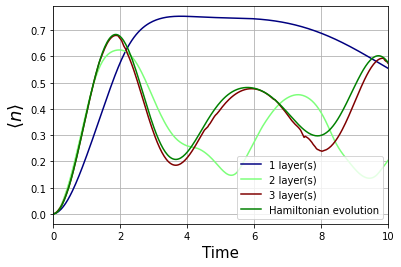

In [233]:
n = 3
colors = plt.cm.jet(np.linspace(0,1,n))

for kkk in range(3):
    plt.plot(time_domain,expt_value_uu[kkk], color = colors[kkk],label = str(kkk+1)+" layer(s)")
plt.plot(time_domain,expt_value_v, color = "g",label = "Hamiltonian evolution")

plt.ylabel(r"$\langle n\rangle$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(0.99,1)

plt.savefig("Real_time_evolution_different_ansatz.pdf")

###### import matplotlib.pyplot as plt
for i in range(coeff*N):
    plt.plot(time_domain, [row[i] for row in Y])
#plt.legend(loc='best')
plt.xlabel('t')
plt.grid()
#plt.xlim(5.9,6.1)
plt.show()

In [212]:
obs = [[1.,2]]
obs_1 = [[-1.,1]]


obs_map = [
            ["z", obs], 
            ["z", obs_1], 


]

observable = hamiltonian(obs_map,dynamic_list=[],basis=basis,**no_checks)
observable_matrix = observable.toarray()
observable_matrix_p = observable_matrix
for i in range(L+1):
    observable_matrix_p = (Proj[i]+Proj_0[i])@observable_matrix_p@(Proj[i]+Proj_0[i])
    
observable_matrix = observable_matrix_p



In [214]:
def hamiltonian_evolution(theta):
    return expm(-1j*full_ham_matrix.toarray()*theta)

def hamiltonian_evolution_1(theta):
    return expm(-1j*constrained_full_ham_matrix.toarray()*theta)

In [218]:
for i in range(coeff*N):
    print(Y[0][i])

0.37141536888406607
0.6602899660443315
0.11637371823579168
0.39901353290549235
0.9247979940631299
0.026453178512319396
0.4382807802429473
0.07025615093206115
0.3606296388374573
0.8138966259351307
0.9031720383192907
0.523454217057356
0.9272695715059814
0.9827474226150743
0.2639324508516817
0.41284186279042756
0.8757225556853009
0.523982524132141
0.9490899608210723
0.6202612047452045
0.19801202641088236
0.6716191124543176


(0.0, 10.0)

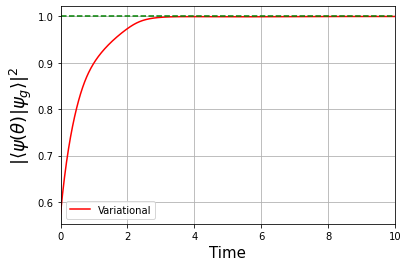

(0.0, 10.0)

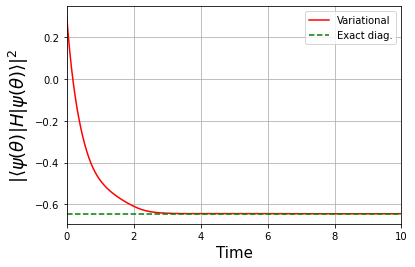

In [220]:
plt.plot(time_domain,energy, color = "red",label = "Variational")
plt.plot(time_domain,eigenval[0]*np.ones(len(time_domain)), ls = "--", color ="g", label = "Exact diag.")

plt.ylabel(r"$|\langle \psi(\theta)|H|\psi(\theta)\rangle|^2$",size = 18)
plt.xlabel('Time',size = 15)
plt.grid()
plt.legend()
plt.xlim(0,10)
#plt.ylim(-0.65,-0.63)

#plt.savefig("Imaginary_time_evolution_energy_3qutrits_M=0.1_N=2_1.pdf")

In [221]:
print(expt_value_u[-1])

0.999481430342308


In [124]:
a = np.array([1,2,4])
ind = [1,3,5]
for i in ind:
    a = np.insert(a,i,i)
    print(a)

[1 1 2 4]
[1 1 2 3 4]
[1 1 2 3 4 5]


In [33]:
vec = np.array([1,2,3,4,5])
print(vec[-1]-vec[0])

4
